# Signate開始時のお約束

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=16d6b3da7d5ee1e96d04a54a226ec00780da992c76b28ad957853caca928ca38
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [ ]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [ ]:
!pip install kanjize

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
!pip install shap

In [ ]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [ ]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

<ipython-input-819-0d12c417dce0>:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

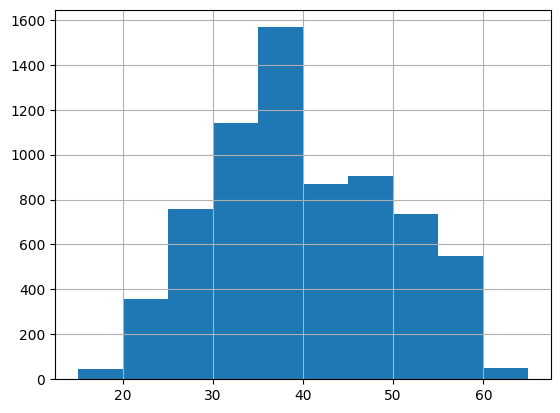

In [ ]:
#####################
# "Age"(年齢)の処理 #
#####################
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10歳で分けて5足す
    tmp = tmp//10 * 10
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

    # 数値変換し5足す
    # tmp = int(tmp)
    # all_df.loc[i,"Age"] = tmp + 5
    # all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

# ヒストグラムの表示
all_df["Age"].hist()

In [ ]:
# 年代のラベリングを追加する
# all_df["AgeTeen"] = all_df["Age"]
# all_df["AgeTeen"] = all_df["AgeTeen"] // 10

<Axes: >

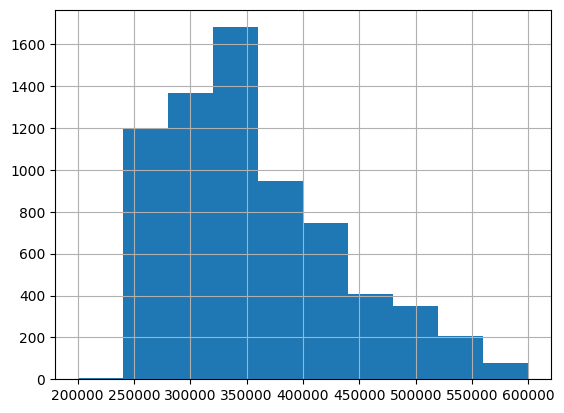

In [ ]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

# 分布の確認
all_df["MonthlyIncome"].hist()

In [ ]:
# 月収と年齢で回帰計算
# x = all_df[["Age"]]
# y = all_df[["MonthlyIncome"]]

# from sklearn.linear_model import LinearRegression

# model_lr = LinearRegression()
# model_lr.fit(x, y)

# print("回帰変数", model_lr.coef_)
# print("切片", model_lr.intercept_)

In [ ]:
# 年齢の割に月収が高いか
# all_df["IncomeAge"] = model_lr.predict(all_df[["Age"]])

# all_df["IncomeCoef"] = 1
# all_df.loc[all_df["MonthlyIncome"]>all_df["IncomeAge"],"IncomeCoef"] = 2


# all_df = all_df.drop("IncomeAge", axis=1)

<Axes: >

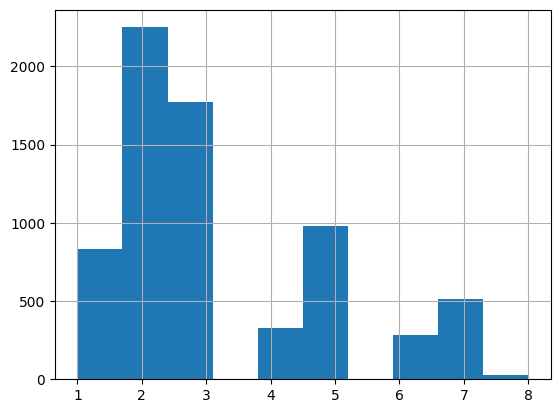

In [ ]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

# ヒストグラムの確認
all_df["NumberOfTrips"].hist()

In [ ]:
# 旅行回数を階層化
# all_df["Weight"] = 1
# all_df.loc[all_df["NumberOfTrips"]>=3,"Weight"] = 3
# all_df.loc[all_df["NumberOfTrips"]>=2,"Weight"] = 2

In [ ]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損を埋める
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

# 分類の確認
all_df["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,4462
Company Invited,2516


In [ ]:
# 連絡手段の順序
Self = all_df.loc[all_df["TypeofContact"]=="Self Enquiry","NumberOfTrips"].median()
Company = all_df.loc[all_df["TypeofContact"]=="Company Invited","NumberOfTrips"].median()

print(Self)
print(Company)

all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact"] = 1
all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact"] = 2

# 旅行回数で割り当てる
# all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact"] = 3
# all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact"] = 2

all_df["TypeofContact"] = all_df["TypeofContact"].astype("int")

all_df["TypeofContact"].value_counts()

3.0
2.0


,count
TypeofContact,
1,4462
2,2516


In [ ]:
#########################
# "CityTier"の処理 #
#########################
# 分類の確認
all_df["CityTier"].value_counts()
# all_df["CityTier"].isnull().sum()

,count
CityTier,
2,3160
1,2991
3,827


<Axes: >

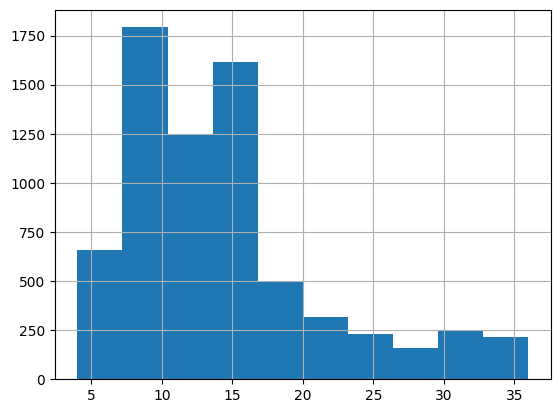

In [ ]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

# 分布の確認
all_df["DurationOfPitch"].hist()

In [ ]:
####################
# "Occupation"の処理 #
####################
# 個人事業主/会社員/大企業の3択のためホットエンコードにする
all_df["Occupation"].value_counts()
# all_df["Occupation"].isnull().sum()

,count
Occupation,
Small Business,3456
Salaried,2801
Large Business,721


In [ ]:
print(all_df.loc[all_df["Occupation"]=="Small Business","NumberOfTrips"].median())
print(all_df.loc[all_df["Occupation"]=="Salaried","NumberOfTrips"].median())
print(all_df.loc[all_df["Occupation"]=="Large Business","NumberOfTrips"].median())

3.0
3.0
3.0


In [ ]:
# 「Occupation」をラベルエンコード(特徴見当たらず)
all_df["Occupation_LE"] = 1
all_df.loc[all_df["Occupation"]=="Large Business","Occupation_LE"] = 3
all_df.loc[all_df["Occupation"]=="Salaried","Occupation_LE"] = 2
all_df.loc[all_df["Occupation"]=="Small Business","Occupation_LE"] = 1
# all_df.loc[all_df["Occupation"]=="Large Business","Occupation_LE"] = 3
# all_df.loc[all_df["Occupation"]=="Salaried","Occupation_LE"] = 1
# all_df.loc[all_df["Occupation"]=="Small Business","Occupation_LE"] = 2

In [ ]:
# 元の列を削除
all_df = all_df.drop("Occupation", axis=1)

In [ ]:
##################
# "Genger"の処理 #
##################
# all_df["Gender"].isnull().sum()
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])

  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"
  else:
    all_df.loc[i,"Gender"] = "Female"

In [ ]:
# 分類の確認
all_df["Gender"].value_counts()

,count
Gender,
Female,5946
Male,1032


In [ ]:
# ターゲットエンコーディング
# 男性の成約率が女性の1.5倍
print(all_df.loc[all_df["Gender"]=="Female","ProdTaken"].mean())
print(all_df.loc[all_df["Gender"]=="Male","ProdTaken"].mean())

0.13767629281396912
0.17025440313111545


In [ ]:
# 「Gender」をラベルエンコード
all_df["Gender_LE"] = 1
# all_df.loc[all_df["Gender"]=="Female","Gender_LE"]=2
# all_df.loc[all_df["Gender"]=="Male","Gender_LE"]=3
all_df.loc[all_df["Gender"]=="Female","Gender_LE"]=2
all_df.loc[all_df["Gender"]=="Male","Gender_LE"]=1

In [ ]:
# 元の列を削除
all_df = all_df.drop("Gender", axis=1)

In [ ]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
all_df["NumberOfPersonVisiting"].value_counts()
# all_df["NumberOfPersonVisiting"].isnull().sum()

,count
NumberOfPersonVisiting,
2.0,3163
3.0,2773
1.0,686
4.0,356


In [ ]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# all_df["NumberOfFollowups"].value_counts()
# all_df["NumberOfFollowups"].isnull().sum()
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

In [ ]:
# 分布の確認
all_df["NumberOfFollowups"].value_counts()

,count
NumberOfFollowups,
4.0,2834
3.0,2561
5.0,1122
2.0,213
1.0,178
6.0,70


In [ ]:
##########################
# "ProductPitched"の処理 #
##########################
# ind_name = all_df["ProductPitched"].value_counts().index.values
# all_df["ProductPitched"].isnull().sum()

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [ ]:
# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

In [ ]:
# 分布の確認
all_df["ProductPitched"].value_counts()

,count
ProductPitched,
Basic,2347
Deluxe,2091
Standard,1614
SuperDeluxe,640
King,286


In [ ]:
# 商品ランクの順序
Basic = all_df.loc[all_df["ProductPitched"]=="Basic","MonthlyIncome"].median()
Deluxe = all_df.loc[all_df["ProductPitched"]=="Deluxe","MonthlyIncome"].median()
Standard = all_df.loc[all_df["ProductPitched"]=="Standard","MonthlyIncome"].median()
SuperDeluxe = all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","MonthlyIncome"].median()
King = all_df.loc[all_df["ProductPitched"]=="King","MonthlyIncome"].median()

# Basicを基準とした商品ランクの間隔
base = Deluxe - Basic # これを「2」とする
print(round((Standard - Basic)/base*2))
print(round((SuperDeluxe - Basic)/base*2))
print(round((King - Basic)/base*2))

5
10
11


In [ ]:
# 「ProductPitched」をラベルエンコード
all_df["ProductPitched_LE"] = 1
# all_df.loc[all_df["ProductPitched"]=="King","ProductPitched_LE"]=10
# all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched_LE"]=8
# all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched_LE"]=6
# all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched_LE"]=4
# all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched_LE"]=2

# all_df["ProductPitched_LE"] = 1
all_df.loc[all_df["ProductPitched"]=="King","ProductPitched_LE"]=5
all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched_LE"]=4
all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched_LE"]=3
all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched_LE"]=2
all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched_LE"]=1

In [ ]:
# 元の列を削除
all_df = all_df.drop("ProductPitched", axis=1)

In [ ]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# all_df["PreferredPropertyStar"].isnull().sum()

# 2引いて揃える
# all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
3.0,4328
4.0,2254
5.0,396


In [ ]:
#########################
# "Passport"の処理 #
#########################
# all_df["Passport"].isnull().sum()
all_df["Passport"].value_counts()

,count
Passport,
0,6288
1,690


In [ ]:
# 1足す
all_df["Passport"] = all_df["Passport"] + 1

<Axes: >

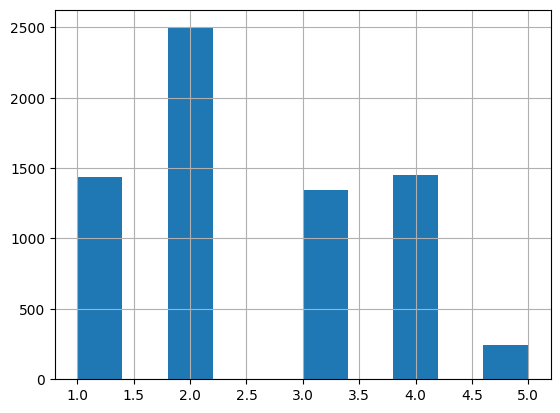

In [ ]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
# all_df["PitchSatisfactionScore"].isnull().sum()
# all_df["PitchSatisfactionScore"].value_counts()
all_df["PitchSatisfactionScore"].hist()

In [ ]:
#########################
# "Designation"の処理 #
#########################
# all_df["Designation"].isnull().sum()
# all_df["Designation"].value_counts()

In [ ]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [ ]:
# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

In [ ]:
# 分類の確認
all_df["Designation"].value_counts()

,count
Designation,
Executive,2330
Manager,2117
Senior Manager,1632
AVP,635
VP,264


300000.0
506745.0
474960.0
386752.5
336195.0


<Axes: >

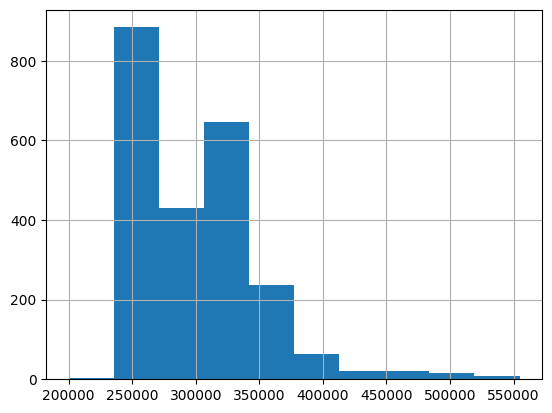

In [ ]:
# 最頻値で確認
print(all_df.loc[all_df["Designation"]=="Executive","MonthlyIncome"].median())
print(all_df.loc[all_df["Designation"]=="VP","MonthlyIncome"].median())
print(all_df.loc[all_df["Designation"]=="AVP","MonthlyIncome"].median())
print(all_df.loc[all_df["Designation"]=="Senior Manager","MonthlyIncome"].median())
print(all_df.loc[all_df["Designation"]=="Manager","MonthlyIncome"].median())

all_df.loc[all_df["Designation"]=="Executive","MonthlyIncome"].hist()

In [ ]:
Executive = all_df.loc[all_df["Designation"]=="Executive","MonthlyIncome"].median()
VP = all_df.loc[all_df["Designation"]=="VP","MonthlyIncome"].median()
AVP = all_df.loc[all_df["Designation"]=="AVP","MonthlyIncome"].median()
Senior = all_df.loc[all_df["Designation"]=="Senior Manager","MonthlyIncome"].median()
Manager = all_df.loc[all_df["Designation"]=="Manager","MonthlyIncome"].median()

print(round((Manager - Executive)/Executive*10))
print(round((Senior - Executive)/Executive*10))
print(round((AVP - Executive)/Executive*10))
print(round((VP - Executive)/Executive*10))

1
3
6
7


In [ ]:
# 「Dsignation」をラベルエンコード
# 社長はほとんどが個人事業主のため給料安い。そのため低く見積もる
# all_df["Designation_LE"] = 1
# all_df.loc[all_df["Designation"]=="VP","Designation_LE"] = 10
# all_df.loc[all_df["Designation"]=="AVP","Designation_LE"] = 8
# all_df.loc[all_df["Designation"]=="Senior Manager","Designation_LE"] = 6
# all_df.loc[all_df["Designation"]=="Manager","Designation_LE"] = 4
# all_df.loc[all_df["Designation"]=="Executive","Designation_LE"] = 2

In [ ]:
all_df["Designation_LE"] = 1
all_df.loc[all_df["Designation"]=="Executive","Designation_LE"] = 5
all_df.loc[all_df["Designation"]=="VP","Designation_LE"] = 4
all_df.loc[all_df["Designation"]=="AVP","Designation_LE"] = 3
all_df.loc[all_df["Designation"]=="Senior Manager","Designation_LE"] = 2
all_df.loc[all_df["Designation"]=="Manager","Designation_LE"] = 1

In [ ]:
# 元の列を削除
all_df = all_df.drop("Designation", axis=1)

In [ ]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [ ]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [ ]:
# 「CarHolder」をラベルエンコード
# all_df["CarHolder_LE"] = all_df["CarHolder"] + 1

In [ ]:
# 車保有率
all_df["CarHolder"].value_counts()

,count
CarHolder,
0,4408
1,2570


In [ ]:
# all_df = all_df.drop("CarHolder", axis=1)

In [ ]:
# 1足す
all_df["NumofChild"] = all_df["NumofChild"] + 1

In [ ]:
# 子供の数
all_df["NumofChild"].value_counts()

,count
NumofChild,
1,5015
2,1347
3,571
4,45


In [ ]:
# 「Married」をラベルエンコード
all_df["Married_LE"] = 1
all_df.loc[all_df["Married"]=="Married","Married_LE"]=3
all_df.loc[all_df["Married"]=="Divorce","Married_LE"]=2
all_df.loc[all_df["Married"]=="Single","Married_LE"]=1

In [ ]:
# 婚姻歴
all_df["Married"].value_counts()

,count
Married,
Married,2846
Single,2444
Divorce,1688


In [ ]:
all_df = all_df.drop("Married", axis=1)

# 特徴量エンジニアリング

In [ ]:
# Logを取る
# all_df["MonthlyIncomeLOG"] = np.log1p(all_df["MonthlyIncome"])
# all_df["AgeLOG"] = np.log1p(all_df["Age"])

# # 削除する
# all_df = all_df.drop("MonthlyIncome", axis=1)
# all_df = all_df.drop("Age", axis=1)

In [ ]:
# クロス特徴量
# 「役職」x「商品ランク」
all_df["Designation_LE_ProductPitched_LE"] = all_df["Designation_LE"] * all_df["ProductPitched_LE"]

In [ ]:
# 「子供の数」x「同行者数」
# all_df["NumofChild_NumberOfPersonVisiting"] = all_df["NumofChild"] * all_df["NumberOfPersonVisiting"]
# 「子供の数」x「車所有」
# all_df["NumofChild_CarHolder"] = all_df["NumofChild"] * all_df["CarHolder"]
# 「満足度」x「商品ランク」
# all_df["PitchSatisfactionScore_ProductPitched_LE"] = all_df["PitchSatisfactionScore"] * all_df["ProductPitched_LE"]
# 「満足度」x「ホテルランク」
all_df["PitchSatisfactionScore_PreferredPropertyStar"] = all_df["PitchSatisfactionScore"] * all_df["PreferredPropertyStar"]

In [ ]:
# all_df.columns
all_df = all_df.drop("PitchSatisfactionScore_PreferredPropertyStar", axis=1)

In [ ]:
# 「パスポート」x「年間旅行数」
# all_df["Passport_NumberOfTrips"] = all_df["Passport"] * all_df["NumberOfTrips"]

In [ ]:
# # 「役職」x「年齢」
# all_df["Designation_LE_Age"] = all_df["Designation_LE"] * all_df["Age"]
# # 「役職」x「都市富裕度」
# all_df["Designation_LE_CityTier"] = all_df["Designation_LE"] * all_df["CityTier"]
# # 「役職」x「セールス時間」
# all_df["Designation_LE_DurationOfPitch"] = all_df["Designation_LE"] * all_df["DurationOfPitch"]
# # 「役職」x「年間旅行数」
# all_df["Designation_LE_NumberOfTrips"] = all_df["Designation_LE"] * all_df["NumberOfTrips"]
# 「月収」/「子供の数」
# all_df["MonthlyIncome_LE_byNumofChild"] = all_df["MonthlyIncome"] / all_df["NumofChild"]
# 「月収」x「婚姻」
# all_df["MonthlyIncome_LE_byMarried"] = all_df["MonthlyIncome"] * all_df["Married_LE"]

In [ ]:
all_df = all_df.drop("Passport_NumberOfTrips", axis=1)

In [ ]:
# 検討の結果、重要度が低いものを抹消する
# all_df = all_df.drop("NumofChild", axis=1)
# all_df = all_df.drop("Gender_LE", axis=1)
# all_df = all_df.drop("CarHolder", axis=1)
# all_df = all_df.drop("Occupation_LE", axis=1)
# all_df = all_df.drop("NumberOfFollowups", axis=1)
# all_df = all_df.drop("PreferredPropertyStar", axis=1)

In [ ]:
# all_df = all_df.drop("NumberOfFollowups", axis=1)

In [ ]:
# クロス特徴量
# all_df["Designation_LE_ProductPitched_LE"] = all_df["Designation_LE"] * all_df["ProductPitched_LE"]

In [ ]:
all_df.columns

Index(['id', 'CityTier', 'DurationOfPitch', 'NumberOfPersonVisiting',
       'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips',
       'Passport', 'PitchSatisfactionScore', 'ProdTaken', 'NumofChild',
       'Designation_LE', 'Occupation_LE', 'CarHolder_LE', 'ProductPitched_LE',
       'Married_LE', 'TypeofContact_LE', 'MonthlyIncomeLOG', 'AgeLOG',
       'Designation_LE_ProductPitched_LE'],
      dtype='object')

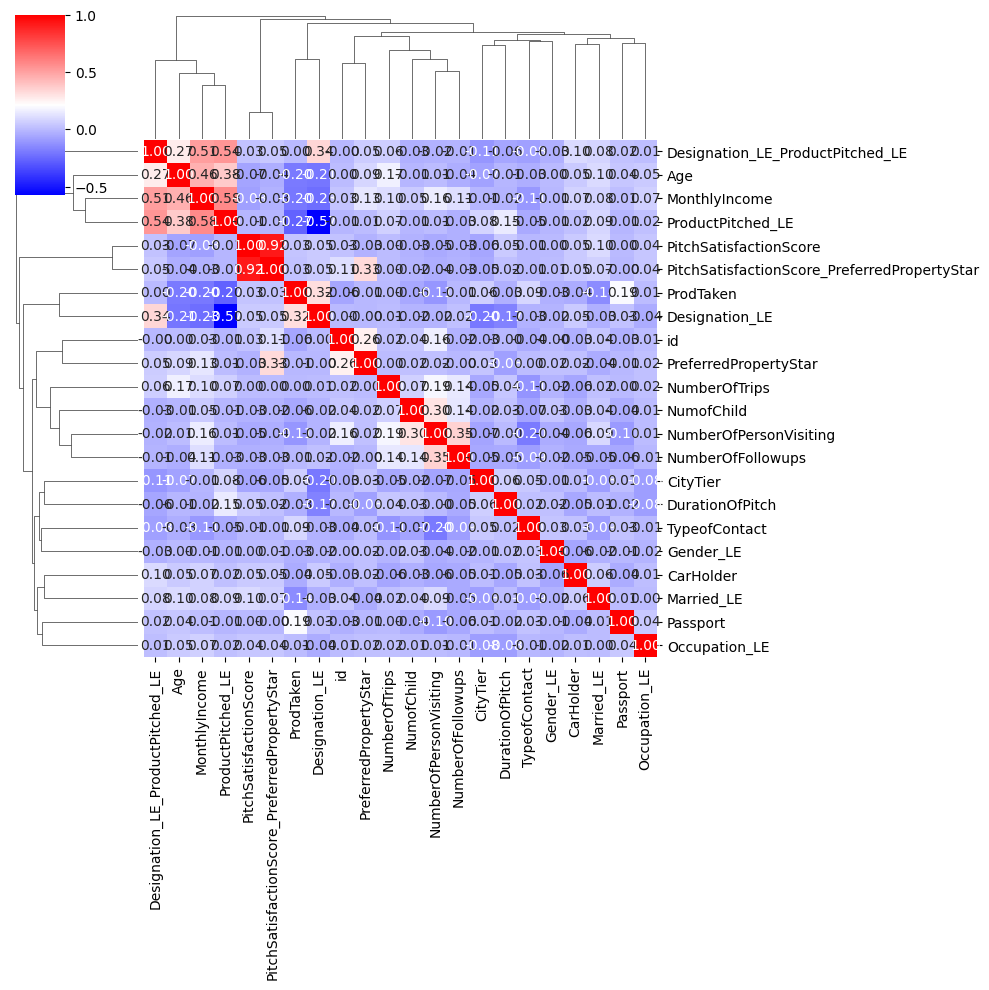

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()

# sns.heatmap(all_df_corr,annot=True,cmap="bwr")
# sns.heatmap(all_df_corr,annot=False,cmap="bwr")
# plt.show()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

# ここで一つの区切り

# ここから学習

In [ ]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [ ]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)

In [ ]:
# カラムを制限
all_df2 = all_df[FEATURES]

# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)
FEATURES = test.columns

In [ ]:
# 1つの基準を作る (learning rate = 0.05)
# FOLDS = 5, seed = 42で最適化
# seed は 3 通りとし、42で超えたら評価に値する

In [ ]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=74)

def objective(trial):

  lgbm_params = {
      'objective': 'binary',
      "device": "cpu",
      'metric': 'auc',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'learning_rate': 0.1,

      'num_leaves': trial.suggest_int('num_leaves', 16, 256),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0,log=True),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0,log=True),
      'max_depth': trial.suggest_int('max_depth', 3, 12),

      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  score = roc_auc_score(train[TARGET],oof_lgb)

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-24 07:07:24,914] A new study created in memory with name: no-name-9d9d574d-973a-4f35-977b-c034acc87f5e
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.988632	valid's auc: 0.819585
#########################
### Fold 2
#########################
[100]	train's auc: 0.988679	valid's auc: 0.795434
#########################
### Fold 3
#########################
[100]	train's auc: 0.985952	valid's auc: 0.809735


[I 2025-05-24 07:07:25,500] Trial 0 finished with value: 0.8201838033548887 and parameters: {'num_leaves': 246, 'min_data_in_leaf': 19, 'feature_fraction': 0.8010566784058244, 'bagging_fraction': 0.5296009178598569, 'bagging_freq': 1, 'lambda_l1': 0.0004044845536458524, 'lambda_l2': 6.201126188155794e-05, 'max_depth': 6}. Best is trial 0 with value: 0.8201838033548887.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.951949	valid's auc: 0.820691
#########################
### Fold 2
#########################
[100]	train's auc: 0.954687	valid's auc: 0.803664
#########################
### Fold 3
#########################
[100]	train's auc: 0.955322	valid's auc: 0.816117


[I 2025-05-24 07:07:26,039] Trial 1 finished with value: 0.8224443586653611 and parameters: {'num_leaves': 226, 'min_data_in_leaf': 56, 'feature_fraction': 0.999415765839881, 'bagging_fraction': 0.9642187091762857, 'bagging_freq': 4, 'lambda_l1': 1.3418617991416292e-07, 'lambda_l2': 1.0986339409448387, 'max_depth': 5}. Best is trial 1 with value: 0.8224443586653611.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.976255	valid's auc: 0.822534
#########################
### Fold 2
#########################
[100]	train's auc: 0.976437	valid's auc: 0.801253
#########################
### Fold 3
#########################
[100]	train's auc: 0.977221	valid's auc: 0.81523


[I 2025-05-24 07:07:26,561] Trial 2 finished with value: 0.8199699534103013 and parameters: {'num_leaves': 29, 'min_data_in_leaf': 54, 'feature_fraction': 0.8824012597503157, 'bagging_fraction': 0.9251241915955004, 'bagging_freq': 1, 'lambda_l1': 8.27082922837193e-06, 'lambda_l2': 1.1871661018919677e-08, 'max_depth': 6}. Best is trial 1 with value: 0.8224443586653611.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.978414	valid's auc: 0.807718
#########################
### Fold 2
#########################
[100]	train's auc: 0.979596	valid's auc: 0.80106
#########################
### Fold 3
#########################


[I 2025-05-24 07:07:27,161] Trial 3 finished with value: 0.8215852602244482 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 40, 'feature_fraction': 0.6355696963367575, 'bagging_fraction': 0.5868711118195784, 'bagging_freq': 2, 'lambda_l1': 1.4445532015312392e-07, 'lambda_l2': 1.147219658905799e-06, 'max_depth': 8}. Best is trial 1 with value: 0.8224443586653611.


[100]	train's auc: 0.975999	valid's auc: 0.810664
#########################
### Fold 1
#########################
[100]	train's auc: 0.89003	valid's auc: 0.826896
#########################
### Fold 2
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.900552	valid's auc: 0.823875
#########################
### Fold 3
#########################
[100]	train's auc: 0.889201	valid's auc: 0.82352


[I 2025-05-24 07:07:27,692] Trial 4 finished with value: 0.8284788947589279 and parameters: {'num_leaves': 18, 'min_data_in_leaf': 23, 'feature_fraction': 0.8681544203636097, 'bagging_fraction': 0.5531792307326118, 'bagging_freq': 1, 'lambda_l1': 1.0379452753407467e-08, 'lambda_l2': 8.125338351777387, 'max_depth': 3}. Best is trial 4 with value: 0.8284788947589279.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.897885	valid's auc: 0.829041
#########################
### Fold 2
#########################
[100]	train's auc: 0.902495	valid's auc: 0.818522
#########################
### Fold 3
#########################
[100]	train's auc: 0.897275	valid's auc: 0.827868


[I 2025-05-24 07:07:28,219] Trial 5 finished with value: 0.8310854431401241 and parameters: {'num_leaves': 226, 'min_data_in_leaf': 97, 'feature_fraction': 0.7117594384927077, 'bagging_fraction': 0.542809157545996, 'bagging_freq': 6, 'lambda_l1': 0.00022819782939504458, 'lambda_l2': 8.776055936079044e-07, 'max_depth': 4}. Best is trial 5 with value: 0.8310854431401241.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.971416	valid's auc: 0.826389
#########################
### Fold 2
#########################
[100]	train's auc: 0.977902	valid's auc: 0.801126
#########################
### Fold 3
#########################


[I 2025-05-24 07:07:28,878] Trial 6 finished with value: 0.8202638289630833 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 72, 'feature_fraction': 0.6005621963690454, 'bagging_fraction': 0.8330900387941789, 'bagging_freq': 5, 'lambda_l1': 6.251154789182854e-05, 'lambda_l2': 2.4175756388381042e-06, 'max_depth': 11}. Best is trial 5 with value: 0.8310854431401241.


[100]	train's auc: 0.969002	valid's auc: 0.82086
#########################
### Fold 1
#########################
[100]	train's auc: 0.898561	valid's auc: 0.830788


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.906302	valid's auc: 0.814467
#########################
### Fold 3
#########################


[I 2025-05-24 07:07:29,435] Trial 7 finished with value: 0.8295602491957089 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 66, 'feature_fraction': 0.6927938951118902, 'bagging_fraction': 0.7022811886871617, 'bagging_freq': 4, 'lambda_l1': 1.0107246084363965e-07, 'lambda_l2': 3.349548173093525e-06, 'max_depth': 3}. Best is trial 5 with value: 0.8310854431401241.


[100]	train's auc: 0.895297	valid's auc: 0.828955
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.999998	valid's auc: 0.816588
#########################
### Fold 2
#########################
[100]	train's auc: 0.999932	valid's auc: 0.796383
#########################
### Fold 3
#########################


[I 2025-05-24 07:07:30,346] Trial 8 finished with value: 0.8154333756549995 and parameters: {'num_leaves': 72, 'min_data_in_leaf': 24, 'feature_fraction': 0.7026440351863856, 'bagging_fraction': 0.94675819296169, 'bagging_freq': 5, 'lambda_l1': 8.019123518578933e-05, 'lambda_l2': 2.4728854507233368e-08, 'max_depth': 11}. Best is trial 5 with value: 0.8310854431401241.


[100]	train's auc: 0.999992	valid's auc: 0.807919
#########################
### Fold 1
#########################
[100]	train's auc: 0.970952	valid's auc: 0.80999


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.973682	valid's auc: 0.80228
#########################
### Fold 3
#########################


[I 2025-05-24 07:07:30,922] Trial 9 finished with value: 0.8192840196257761 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 15, 'feature_fraction': 0.8366864575841637, 'bagging_fraction': 0.5721350287240989, 'bagging_freq': 6, 'lambda_l1': 0.041271755169229415, 'lambda_l2': 0.07035928105916867, 'max_depth': 5}. Best is trial 5 with value: 0.8310854431401241.


[100]	train's auc: 0.973103	valid's auc: 0.822342
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.890516	valid's auc: 0.834606
#########################
### Fold 2
#########################
[100]	train's auc: 0.905346	valid's auc: 0.8226
#########################
### Fold 3
#########################
[100]	train's auc: 0.891548	valid's auc: 0.826356


[I 2025-05-24 07:07:31,541] Trial 10 finished with value: 0.831814415907208 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 100, 'feature_fraction': 0.51692218428844, 'bagging_fraction': 0.6673882667717735, 'bagging_freq': 7, 'lambda_l1': 2.2302436280911704, 'lambda_l2': 0.004672754917477963, 'max_depth': 9}. Best is trial 10 with value: 0.831814415907208.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.865605	valid's auc: 0.836038
#########################
### Fold 2
#########################
[100]	train's auc: 0.871113	valid's auc: 0.827005
[200]	train's auc: 0.881236	valid's auc: 0.82796
#########################
### Fold 3
#########################
[100]	train's auc: 0.86265	valid's auc: 0.824327
[200]	train's auc: 0.873216	valid's auc: 0.825542


[I 2025-05-24 07:07:32,322] Trial 11 finished with value: 0.8292502340244675 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 99, 'feature_fraction': 0.5215387375020044, 'bagging_fraction': 0.6841628724405451, 'bagging_freq': 7, 'lambda_l1': 6.136732766539681, 'lambda_l2': 0.0046072875335483226, 'max_depth': 9}. Best is trial 10 with value: 0.831814415907208.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.918494	valid's auc: 0.833712
#########################
### Fold 2
#########################
[100]	train's auc: 0.929858	valid's auc: 0.81828
#########################
### Fold 3
#########################
[100]	train's auc: 0.916365	valid's auc: 0.827273


[I 2025-05-24 07:07:35,815] Trial 12 finished with value: 0.8307639957391408 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 98, 'feature_fraction': 0.5217155753652833, 'bagging_fraction': 0.646312513182965, 'bagging_freq': 7, 'lambda_l1': 0.07800976357635026, 'lambda_l2': 0.0008077770304284878, 'max_depth': 9}. Best is trial 10 with value: 0.831814415907208.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.953927	valid's auc: 0.824304
#########################
### Fold 2
#########################
[100]	train's auc: 0.961196	valid's auc: 0.808099
#########################
### Fold 3
#########################
[100]	train's auc: 0.952745	valid's auc: 0.825536


[I 2025-05-24 07:07:36,470] Trial 13 finished with value: 0.8250082043060503 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 83, 'feature_fraction': 0.5896526177202138, 'bagging_fraction': 0.7791534305719403, 'bagging_freq': 6, 'lambda_l1': 0.006912084660205293, 'lambda_l2': 9.572276638627278e-05, 'max_depth': 12}. Best is trial 10 with value: 0.831814415907208.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.862931	valid's auc: 0.834824
#########################
### Fold 2
#########################
[100]	train's auc: 0.868064	valid's auc: 0.826649
[200]	train's auc: 0.874714	valid's auc: 0.828322
#########################
### Fold 3
#########################


[I 2025-05-24 07:07:37,159] Trial 14 finished with value: 0.8299018711197667 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 88, 'feature_fraction': 0.753625068578574, 'bagging_fraction': 0.6252250701698275, 'bagging_freq': 6, 'lambda_l1': 7.554423479679801, 'lambda_l2': 0.019781272873999407, 'max_depth': 8}. Best is trial 10 with value: 0.831814415907208.


[100]	train's auc: 0.863868	valid's auc: 0.827212
[200]	train's auc: 0.874622	valid's auc: 0.825427
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.912696	valid's auc: 0.820878
#########################
### Fold 2
#########################
[100]	train's auc: 0.924311	valid's auc: 0.818764


[I 2025-05-24 07:07:37,727] Trial 15 finished with value: 0.8261833702751267 and parameters: {'num_leaves': 207, 'min_data_in_leaf': 82, 'feature_fraction': 0.6656511108377335, 'bagging_fraction': 0.502241724847937, 'bagging_freq': 7, 'lambda_l1': 0.004381707301493968, 'lambda_l2': 1.507806384957521e-07, 'max_depth': 10}. Best is trial 10 with value: 0.831814415907208.


#########################
### Fold 3
#########################
[100]	train's auc: 0.912635	valid's auc: 0.822919


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.941326	valid's auc: 0.822395
#########################
### Fold 2
#########################
[100]	train's auc: 0.948503	valid's auc: 0.817875


[I 2025-05-24 07:07:38,368] Trial 16 finished with value: 0.824151459559496 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 94, 'feature_fraction': 0.9499883889754193, 'bagging_fraction': 0.7607781302972251, 'bagging_freq': 3, 'lambda_l1': 0.2937207806139483, 'lambda_l2': 1.5527803315479267e-05, 'max_depth': 7}. Best is trial 10 with value: 0.831814415907208.


#########################
### Fold 3
#########################
[100]	train's auc: 0.942822	valid's auc: 0.823253


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.921898	valid's auc: 0.829289
#########################
### Fold 2
#########################
[100]	train's auc: 0.931236	valid's auc: 0.814927
#########################
### Fold 3
#########################


[I 2025-05-24 07:07:38,996] Trial 17 finished with value: 0.8240939621687345 and parameters: {'num_leaves': 246, 'min_data_in_leaf': 73, 'feature_fraction': 0.7518508885720283, 'bagging_fraction': 0.8369549890138144, 'bagging_freq': 5, 'lambda_l1': 6.335637025787243e-06, 'lambda_l2': 0.0010547075817038281, 'max_depth': 4}. Best is trial 10 with value: 0.831814415907208.


[100]	train's auc: 0.919998	valid's auc: 0.825657
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.973279	valid's auc: 0.818703
#########################
### Fold 2
#########################
[100]	train's auc: 0.97403	valid's auc: 0.813652
#########################
### Fold 3
#########################
[100]	train's auc: 0.969759	valid's auc: 0.816251


[I 2025-05-24 07:07:39,652] Trial 18 finished with value: 0.8277801837764555 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 40, 'feature_fraction': 0.5673666140995685, 'bagging_fraction': 0.6249281329566844, 'bagging_freq': 6, 'lambda_l1': 0.0014824017271334252, 'lambda_l2': 0.1293409283376234, 'max_depth': 7}. Best is trial 10 with value: 0.831814415907208.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.926304	valid's auc: 0.826794
#########################
### Fold 2
#########################
[100]	train's auc: 0.935612	valid's auc: 0.824848
#########################
### Fold 3
#########################
[100]	train's auc: 0.927457	valid's auc: 0.830443


[I 2025-05-24 07:07:40,209] Trial 19 finished with value: 0.8307488648468351 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 89, 'feature_fraction': 0.5032563446659694, 'bagging_fraction': 0.7041513784679887, 'bagging_freq': 7, 'lambda_l1': 0.5316359698785545, 'lambda_l2': 0.0045178110539703135, 'max_depth': 9}. Best is trial 10 with value: 0.831814415907208.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.923811	valid's auc: 0.824939
#########################
### Fold 2
#########################
[100]	train's auc: 0.933364	valid's auc: 0.821827
#########################
### Fold 3
#########################


[I 2025-05-24 07:07:40,879] Trial 20 finished with value: 0.8284365282604719 and parameters: {'num_leaves': 217, 'min_data_in_leaf': 77, 'feature_fraction': 0.7917169604818611, 'bagging_fraction': 0.5930663875260482, 'bagging_freq': 4, 'lambda_l1': 4.187939669056947e-06, 'lambda_l2': 8.34792385819787e-08, 'max_depth': 5}. Best is trial 10 with value: 0.831814415907208.


[100]	train's auc: 0.926125	valid's auc: 0.813548
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.917685	valid's auc: 0.828304
#########################
### Fold 2
#########################
[100]	train's auc: 0.930399	valid's auc: 0.822498


[I 2025-05-24 07:07:41,442] Trial 21 finished with value: 0.8306648043340255 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 99, 'feature_fraction': 0.5510940467276303, 'bagging_fraction': 0.6514693104824623, 'bagging_freq': 7, 'lambda_l1': 0.15448428538182676, 'lambda_l2': 0.0006170816197974577, 'max_depth': 9}. Best is trial 10 with value: 0.831814415907208.


#########################
### Fold 3
#########################
[100]	train's auc: 0.918966	valid's auc: 0.826477


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.906767	valid's auc: 0.832377
#########################
### Fold 2
#########################
[100]	train's auc: 0.920969	valid's auc: 0.827102
#########################
### Fold 3
#########################


[I 2025-05-24 07:07:42,111] Trial 22 finished with value: 0.8268941859714436 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 92, 'feature_fraction': 0.633796874699267, 'bagging_fraction': 0.6554976749525777, 'bagging_freq': 7, 'lambda_l1': 1.4229011263482751, 'lambda_l2': 8.869091097285065e-05, 'max_depth': 10}. Best is trial 10 with value: 0.831814415907208.


[100]	train's auc: 0.906622	valid's auc: 0.819251
[200]	train's auc: 0.940286	valid's auc: 0.816026


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.901438	valid's auc: 0.831942
#########################
### Fold 2
#########################
[100]	train's auc: 0.910924	valid's auc: 0.816365
#########################
### Fold 3
#########################
[100]	train's auc: 0.899595	valid's auc: 0.832939


[I 2025-05-24 07:07:42,713] Trial 23 finished with value: 0.8303241911361214 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 98, 'feature_fraction': 0.5220570704758281, 'bagging_fraction': 0.5157820325427009, 'bagging_freq': 6, 'lambda_l1': 0.02506475574837102, 'lambda_l2': 0.0024194805800325523, 'max_depth': 10}. Best is trial 10 with value: 0.831814415907208.


[200]	train's auc: 0.933703	valid's auc: 0.821018
#########################
### Fold 1
#########################
[100]	train's auc: 0.940548	valid's auc: 0.8266


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.950809	valid's auc: 0.813827
#########################
### Fold 3
#########################


[I 2025-05-24 07:07:43,324] Trial 24 finished with value: 0.8291251519814072 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 86, 'feature_fraction': 0.554336042501779, 'bagging_fraction': 0.7243532849502042, 'bagging_freq': 7, 'lambda_l1': 0.035973650082000576, 'lambda_l2': 1.4048745413904941e-05, 'max_depth': 8}. Best is trial 10 with value: 0.831814415907208.


[100]	train's auc: 0.939455	valid's auc: 0.825196
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.905131	valid's auc: 0.830667
#########################
### Fold 2
#########################
[100]	train's auc: 0.918665	valid's auc: 0.81857


[I 2025-05-24 07:07:43,908] Trial 25 finished with value: 0.826848120810424 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 63, 'feature_fraction': 0.6180580868996969, 'bagging_fraction': 0.6236284726939587, 'bagging_freq': 6, 'lambda_l1': 2.503345825539626, 'lambda_l2': 0.00028968409115798515, 'max_depth': 7}. Best is trial 10 with value: 0.831814415907208.


#########################
### Fold 3
#########################
[100]	train's auc: 0.907201	valid's auc: 0.816597


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.945989	valid's auc: 0.823186
#########################
### Fold 2
#########################


[I 2025-05-24 07:07:44,435] Trial 26 finished with value: 0.825236848900892 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 79, 'feature_fraction': 0.7106964832108471, 'bagging_fraction': 0.6702906475054639, 'bagging_freq': 5, 'lambda_l1': 0.00116492451751788, 'lambda_l2': 0.015218298549554612, 'max_depth': 9}. Best is trial 10 with value: 0.831814415907208.


[100]	train's auc: 0.954696	valid's auc: 0.800365
#########################
### Fold 3
#########################
[100]	train's auc: 0.945282	valid's auc: 0.820386


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.937831	valid's auc: 0.833791
#########################
### Fold 2
#########################
[100]	train's auc: 0.947317	valid's auc: 0.81425
#########################
### Fold 3
#########################


[I 2025-05-24 07:07:45,037] Trial 27 finished with value: 0.8263235832104929 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 100, 'feature_fraction': 0.6523378394979997, 'bagging_fraction': 0.7949893343394613, 'bagging_freq': 7, 'lambda_l1': 7.574710324976637e-05, 'lambda_l2': 0.18332646304020905, 'max_depth': 11}. Best is trial 10 with value: 0.831814415907208.


[100]	train's auc: 0.94157	valid's auc: 0.818127
#########################
### Fold 1
#########################
[100]	train's auc: 0.907298	valid's auc: 0.830365


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.915384	valid's auc: 0.822099
#########################
### Fold 3
#########################
[100]	train's auc: 0.904447	valid's auc: 0.829842


[I 2025-05-24 07:07:45,802] Trial 28 finished with value: 0.8301876768633191 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 92, 'feature_fraction': 0.5023766434695973, 'bagging_fraction': 0.5405078640052161, 'bagging_freq': 6, 'lambda_l1': 0.13271862681247268, 'lambda_l2': 2.2124545849919552e-07, 'max_depth': 6}. Best is trial 10 with value: 0.831814415907208.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.931298	valid's auc: 0.826516
#########################
### Fold 2
#########################
[100]	train's auc: 0.941269	valid's auc: 0.807338
#########################
### Fold 3
#########################
[100]	train's auc: 0.933721	valid's auc: 0.829143


[I 2025-05-24 07:07:49,115] Trial 29 finished with value: 0.8271292191652589 and parameters: {'num_leaves': 239, 'min_data_in_leaf': 42, 'feature_fraction': 0.5694751928900378, 'bagging_fraction': 0.7255973113561827, 'bagging_freq': 5, 'lambda_l1': 0.000382981961806979, 'lambda_l2': 2.1595807541091043e-05, 'max_depth': 4}. Best is trial 10 with value: 0.831814415907208.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.9076	valid's auc: 0.833198
#########################
### Fold 2
#########################
[100]	train's auc: 0.921274	valid's auc: 0.819428
#########################
### Fold 3
#########################
[100]	train's auc: 0.911454	valid's auc: 0.8259


[I 2025-05-24 07:07:49,720] Trial 30 finished with value: 0.8307142319155575 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 93, 'feature_fraction': 0.546916317769712, 'bagging_fraction': 0.6125908393345916, 'bagging_freq': 3, 'lambda_l1': 0.8803632804737298, 'lambda_l2': 0.0002757129393726896, 'max_depth': 8}. Best is trial 10 with value: 0.831814415907208.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.927111	valid's auc: 0.826782
#########################
### Fold 2
#########################
[100]	train's auc: 0.941329	valid's auc: 0.822365
#########################
### Fold 3
#########################


[I 2025-05-24 07:07:50,333] Trial 31 finished with value: 0.8296557419382606 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 88, 'feature_fraction': 0.5077384919287352, 'bagging_fraction': 0.7059431522006518, 'bagging_freq': 7, 'lambda_l1': 0.41301896288960227, 'lambda_l2': 0.009006289842181584, 'max_depth': 9}. Best is trial 10 with value: 0.831814415907208.


[100]	train's auc: 0.929027	valid's auc: 0.825044
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.925719	valid's auc: 0.833434
#########################
### Fold 2
#########################
[100]	train's auc: 0.936064	valid's auc: 0.819054
#########################
### Fold 3
#########################
[100]	train's auc: 0.926649	valid's auc: 0.826878


[I 2025-05-24 07:07:51,002] Trial 32 finished with value: 0.8299052335402791 and parameters: {'num_leaves': 44, 'min_data_in_leaf': 89, 'feature_fraction': 0.5931749714704178, 'bagging_fraction': 0.6610248559027562, 'bagging_freq': 7, 'lambda_l1': 0.008822024307372231, 'lambda_l2': 0.6477421168578318, 'max_depth': 10}. Best is trial 10 with value: 0.831814415907208.


[200]	train's auc: 0.961849	valid's auc: 0.812886
#########################
### Fold 1
#########################
[100]	train's auc: 0.895726	valid's auc: 0.82947


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.906393	valid's auc: 0.830002
#########################
### Fold 3
#########################
[100]	train's auc: 0.895828	valid's auc: 0.826921


[I 2025-05-24 07:07:51,681] Trial 33 finished with value: 0.8304580154725142 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 95, 'feature_fraction': 0.5419142741735238, 'bagging_fraction': 0.7397615088384826, 'bagging_freq': 7, 'lambda_l1': 2.632835760484546, 'lambda_l2': 0.0012518641094984128, 'max_depth': 9}. Best is trial 10 with value: 0.831814415907208.


[200]	train's auc: 0.922489	valid's auc: 0.823483
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.920428	valid's auc: 0.827531
#########################
### Fold 2
#########################
[100]	train's auc: 0.931504	valid's auc: 0.812286
#########################
### Fold 3
#########################
[100]	train's auc: 0.919971	valid's auc: 0.813439


[I 2025-05-24 07:07:52,355] Trial 34 finished with value: 0.8317061459667094 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 84, 'feature_fraction': 0.9355380179838008, 'bagging_fraction': 0.5680142322014775, 'bagging_freq': 6, 'lambda_l1': 0.09036994393048069, 'lambda_l2': 0.03483923423629255, 'max_depth': 6}. Best is trial 10 with value: 0.831814415907208.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.914487	valid's auc: 0.827325
#########################
### Fold 2
#########################
[100]	train's auc: 0.922248	valid's auc: 0.818135
#########################
### Fold 3
#########################
[100]	train's auc: 0.913483	valid's auc: 0.817149


[I 2025-05-24 07:07:52,874] Trial 35 finished with value: 0.8251642206178247 and parameters: {'num_leaves': 229, 'min_data_in_leaf': 81, 'feature_fraction': 0.9430006640734013, 'bagging_fraction': 0.5568594024986636, 'bagging_freq': 6, 'lambda_l1': 0.10161439405641803, 'lambda_l2': 2.024402795095503, 'max_depth': 6}. Best is trial 10 with value: 0.831814415907208.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.913691	valid's auc: 0.829204
#########################
### Fold 2
#########################


[I 2025-05-24 07:07:53,386] Trial 36 finished with value: 0.8274597451016258 and parameters: {'num_leaves': 206, 'min_data_in_leaf': 71, 'feature_fraction': 0.9839748423466161, 'bagging_fraction': 0.5902034960452311, 'bagging_freq': 6, 'lambda_l1': 0.0013053434143921675, 'lambda_l2': 0.04086816417021355, 'max_depth': 4}. Best is trial 10 with value: 0.831814415907208.


[100]	train's auc: 0.922757	valid's auc: 0.818715
#########################
### Fold 3
#########################
[100]	train's auc: 0.908776	valid's auc: 0.817022


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.896993	valid's auc: 0.824461
#########################
### Fold 2
#########################


[I 2025-05-24 07:07:53,861] Trial 37 finished with value: 0.8309371603955282 and parameters: {'num_leaves': 253, 'min_data_in_leaf': 59, 'feature_fraction': 0.8895480502486247, 'bagging_fraction': 0.5485764297073699, 'bagging_freq': 4, 'lambda_l1': 0.00018043608475770074, 'lambda_l2': 7.225010634113899e-07, 'max_depth': 3}. Best is trial 10 with value: 0.831814415907208.


[100]	train's auc: 0.904049	valid's auc: 0.823621
#########################
### Fold 3
#########################
[100]	train's auc: 0.894503	valid's auc: 0.822026


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.89359	valid's auc: 0.82483
#########################
### Fold 2
#########################
[100]	train's auc: 0.903549	valid's auc: 0.823978
#########################
### Fold 3
#########################
[100]	train's auc: 0.890429	valid's auc: 0.81939


[I 2025-05-24 07:07:54,389] Trial 38 finished with value: 0.8291607936388383 and parameters: {'num_leaves': 251, 'min_data_in_leaf': 61, 'feature_fraction': 0.898563250444381, 'bagging_fraction': 0.534570849573818, 'bagging_freq': 4, 'lambda_l1': 2.1560017909975884e-05, 'lambda_l2': 6.475370685497688e-07, 'max_depth': 3}. Best is trial 10 with value: 0.831814415907208.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.906896	valid's auc: 0.825803
#########################
### Fold 2
#########################
[100]	train's auc: 0.918109	valid's auc: 0.814111
#########################
### Fold 3
#########################
[100]	train's auc: 0.905688	valid's auc: 0.816761


[I 2025-05-24 07:07:54,887] Trial 39 finished with value: 0.8265488653848223 and parameters: {'num_leaves': 228, 'min_data_in_leaf': 31, 'feature_fraction': 0.8374833812562364, 'bagging_fraction': 0.5727373706920703, 'bagging_freq': 3, 'lambda_l1': 6.831316903810496e-07, 'lambda_l2': 1.0004240642131831e-08, 'max_depth': 3}. Best is trial 10 with value: 0.831814415907208.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.940428	valid's auc: 0.81657
#########################
### Fold 2
#########################
[100]	train's auc: 0.944226	valid's auc: 0.808739
#########################
### Fold 3
#########################
[100]	train's auc: 0.936569	valid's auc: 0.820987


[I 2025-05-24 07:07:55,495] Trial 40 finished with value: 0.8269758927898944 and parameters: {'num_leaves': 198, 'min_data_in_leaf': 53, 'feature_fraction': 0.9248339982417476, 'bagging_fraction': 0.5550005097382443, 'bagging_freq': 5, 'lambda_l1': 0.0002270267802266467, 'lambda_l2': 1.059489901865151e-06, 'max_depth': 5}. Best is trial 10 with value: 0.831814415907208.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.915508	valid's auc: 0.817519
#########################
### Fold 2
#########################


[I 2025-05-24 07:07:55,971] Trial 41 finished with value: 0.8286493694789054 and parameters: {'num_leaves': 218, 'min_data_in_leaf': 55, 'feature_fraction': 0.8670436203216839, 'bagging_fraction': 0.5242802256058439, 'bagging_freq': 4, 'lambda_l1': 1.919288878363147e-05, 'lambda_l2': 4.973982477527336e-06, 'max_depth': 4}. Best is trial 10 with value: 0.831814415907208.


[100]	train's auc: 0.928269	valid's auc: 0.816329
#########################
### Fold 3
#########################
[100]	train's auc: 0.915672	valid's auc: 0.810372


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.918337	valid's auc: 0.82222
#########################
### Fold 2
#########################
[100]	train's auc: 0.924253	valid's auc: 0.811428
#########################
### Fold 3
#########################


[I 2025-05-24 07:07:56,555] Trial 42 finished with value: 0.8272711133108813 and parameters: {'num_leaves': 237, 'min_data_in_leaf': 95, 'feature_fraction': 0.9952486649953142, 'bagging_fraction': 0.6020011974751109, 'bagging_freq': 5, 'lambda_l1': 0.00021046271047425676, 'lambda_l2': 4.3308883659668075e-08, 'max_depth': 5}. Best is trial 10 with value: 0.831814415907208.


[100]	train's auc: 0.90941	valid's auc: 0.807451
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.902006	valid's auc: 0.832612
#########################
### Fold 2
#########################
[100]	train's auc: 0.912765	valid's auc: 0.820649


[I 2025-05-24 07:07:57,083] Trial 43 finished with value: 0.8321973956035679 and parameters: {'num_leaves': 254, 'min_data_in_leaf': 49, 'feature_fraction': 0.8399612262619843, 'bagging_fraction': 0.5636165915194414, 'bagging_freq': 1, 'lambda_l1': 0.01703196585291516, 'lambda_l2': 3.9585431722729216e-07, 'max_depth': 3}. Best is trial 43 with value: 0.8321973956035679.


#########################
### Fold 3
#########################
[100]	train's auc: 0.904296	valid's auc: 0.828949


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.8992	valid's auc: 0.832377
#########################
### Fold 2
#########################
[100]	train's auc: 0.910121	valid's auc: 0.824202
#########################
### Fold 3
#########################
[100]	train's auc: 0.901778	valid's auc: 0.825074


[I 2025-05-24 07:07:57,664] Trial 44 finished with value: 0.8290094847157813 and parameters: {'num_leaves': 252, 'min_data_in_leaf': 45, 'feature_fraction': 0.8161545842191947, 'bagging_fraction': 0.5001255355146911, 'bagging_freq': 1, 'lambda_l1': 0.014442963973638215, 'lambda_l2': 2.7278667380061395e-07, 'max_depth': 3}. Best is trial 43 with value: 0.8321973956035679.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.900738	valid's auc: 0.828667
#########################
### Fold 2
#########################


[I 2025-05-24 07:07:58,142] Trial 45 finished with value: 0.827657791669805 and parameters: {'num_leaves': 255, 'min_data_in_leaf': 51, 'feature_fraction': 0.8968350167888146, 'bagging_fraction': 0.5709524453732632, 'bagging_freq': 1, 'lambda_l1': 0.0007556345614971681, 'lambda_l2': 5.172354052585027e-06, 'max_depth': 3}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.911121	valid's auc: 0.815972
#########################
### Fold 3
#########################
[100]	train's auc: 0.902941	valid's auc: 0.827923


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.944205	valid's auc: 0.828775
#########################
### Fold 2
#########################
[100]	train's auc: 0.953562	valid's auc: 0.804105
#########################
### Fold 3
#########################
[100]	train's auc: 0.946168	valid's auc: 0.822196


[I 2025-05-24 07:08:01,616] Trial 46 finished with value: 0.8264849793950871 and parameters: {'num_leaves': 238, 'min_data_in_leaf': 33, 'feature_fraction': 0.7806041530134344, 'bagging_fraction': 0.9003984350255805, 'bagging_freq': 2, 'lambda_l1': 0.003011193466095591, 'lambda_l2': 5.715121534667283e-07, 'max_depth': 4}. Best is trial 43 with value: 0.8321973956035679.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.965026	valid's auc: 0.806842
#########################
### Fold 2
#########################
[100]	train's auc: 0.961575	valid's auc: 0.801404
#########################
### Fold 3
#########################
[100]	train's auc: 0.955535	valid's auc: 0.805721


[I 2025-05-24 07:08:02,176] Trial 47 finished with value: 0.8215317977383014 and parameters: {'num_leaves': 218, 'min_data_in_leaf': 47, 'feature_fraction': 0.8639049206999275, 'bagging_fraction': 0.5415704880173535, 'bagging_freq': 3, 'lambda_l1': 2.3616685463960203e-06, 'lambda_l2': 1.6786398337756068e-06, 'max_depth': 6}. Best is trial 43 with value: 0.8321973956035679.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.897305	valid's auc: 0.829978
#########################
### Fold 2
#########################
[100]	train's auc: 0.90163	valid's auc: 0.820328
#########################
### Fold 3
#########################


[I 2025-05-24 07:08:02,725] Trial 48 finished with value: 0.8311557177288329 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 66, 'feature_fraction': 0.7254884346505538, 'bagging_fraction': 0.5767296902376935, 'bagging_freq': 2, 'lambda_l1': 2.24045379324331e-05, 'lambda_l2': 3.479851571339171e-08, 'max_depth': 3}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.894889	valid's auc: 0.824485
#########################
### Fold 1
#########################
[100]	train's auc: 0.917916	valid's auc: 0.820093


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.920166	valid's auc: 0.812957
#########################
### Fold 3
#########################


[I 2025-05-24 07:08:03,245] Trial 49 finished with value: 0.8271621708862802 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 70, 'feature_fraction': 0.725996931120227, 'bagging_fraction': 0.5802676006560296, 'bagging_freq': 2, 'lambda_l1': 2.5973886674869053e-05, 'lambda_l2': 1.6247581844917744e-08, 'max_depth': 4}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.913883	valid's auc: 0.821534
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.943778	valid's auc: 0.822087
#########################
### Fold 2
#########################
[100]	train's auc: 0.943024	valid's auc: 0.808721
#########################
### Fold 3
#########################


[I 2025-05-24 07:08:03,816] Trial 50 finished with value: 0.8233851639247249 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 84, 'feature_fraction': 0.764723140593938, 'bagging_fraction': 0.9957399713072924, 'bagging_freq': 1, 'lambda_l1': 1.0758463360281593e-06, 'lambda_l2': 4.661722850936907e-08, 'max_depth': 5}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.941693	valid's auc: 0.81772
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.895041	valid's auc: 0.824546
#########################
### Fold 2
#########################
[100]	train's auc: 0.900896	valid's auc: 0.814679
#########################
### Fold 3
#########################


[I 2025-05-24 07:08:04,306] Trial 51 finished with value: 0.8294936732695639 and parameters: {'num_leaves': 205, 'min_data_in_leaf': 66, 'feature_fraction': 0.8337499291864043, 'bagging_fraction': 0.5197858775348783, 'bagging_freq': 2, 'lambda_l1': 0.00012765487693800794, 'lambda_l2': 7.677947580676772e-08, 'max_depth': 3}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.890506	valid's auc: 0.821607
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.896834	valid's auc: 0.82909
#########################
### Fold 2
#########################
[100]	train's auc: 0.907371	valid's auc: 0.816183
#########################
### Fold 3
#########################


[I 2025-05-24 07:08:04,873] Trial 52 finished with value: 0.8276443419877554 and parameters: {'num_leaves': 241, 'min_data_in_leaf': 60, 'feature_fraction': 0.679904122149015, 'bagging_fraction': 0.5591587739634891, 'bagging_freq': 1, 'lambda_l1': 3.827227474510762e-05, 'lambda_l2': 3.0641480407019453e-07, 'max_depth': 3}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.89775	valid's auc: 0.820617
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.933715	valid's auc: 0.818486
#########################
### Fold 2
#########################
[100]	train's auc: 0.933577	valid's auc: 0.808764


[I 2025-05-24 07:08:05,431] Trial 53 finished with value: 0.8246450628907133 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 49, 'feature_fraction': 0.9516221762671446, 'bagging_fraction': 0.6040394709584948, 'bagging_freq': 2, 'lambda_l1': 0.0005680945889136397, 'lambda_l2': 1.2875327685124374e-07, 'max_depth': 4}. Best is trial 43 with value: 0.8321973956035679.


#########################
### Fold 3
#########################
[100]	train's auc: 0.926357	valid's auc: 0.820174


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.897399	valid's auc: 0.832721
#########################
### Fold 2
#########################


[I 2025-05-24 07:08:05,898] Trial 54 finished with value: 0.8292569588654923 and parameters: {'num_leaves': 225, 'min_data_in_leaf': 57, 'feature_fraction': 0.7227618389788764, 'bagging_fraction': 0.6333722338313973, 'bagging_freq': 4, 'lambda_l1': 1.0671747884274765e-05, 'lambda_l2': 2.9664487384606113e-08, 'max_depth': 3}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.909173	valid's auc: 0.820026
#########################
### Fold 3
#########################
[100]	train's auc: 0.897645	valid's auc: 0.823617


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.929822	valid's auc: 0.832377
#########################
### Fold 2
#########################


[I 2025-05-24 07:08:06,457] Trial 55 finished with value: 0.8297539246172221 and parameters: {'num_leaves': 213, 'min_data_in_leaf': 76, 'feature_fraction': 0.9191323564808918, 'bagging_fraction': 0.5827968287111325, 'bagging_freq': 2, 'lambda_l1': 0.003099895638895824, 'lambda_l2': 4.2103038611435684e-05, 'max_depth': 5}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.930279	valid's auc: 0.816715
#########################
### Fold 3
#########################
[100]	train's auc: 0.921889	valid's auc: 0.817441


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.927485	valid's auc: 0.827162
#########################
### Fold 2
#########################


[I 2025-05-24 07:08:06,935] Trial 56 finished with value: 0.8253834504352318 and parameters: {'num_leaves': 231, 'min_data_in_leaf': 67, 'feature_fraction': 0.9688865104639035, 'bagging_fraction': 0.6750908945707856, 'bagging_freq': 1, 'lambda_l1': 9.158867272251626e-05, 'lambda_l2': 0.04138573361094969, 'max_depth': 4}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.929264	valid's auc: 0.813066
#########################
### Fold 3
#########################
[100]	train's auc: 0.928273	valid's auc: 0.824242


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.902572	valid's auc: 0.820661
#########################
### Fold 2
#########################
[100]	train's auc: 0.915173	valid's auc: 0.806419
#########################
### Fold 3
#########################
[100]	train's auc: 0.903926	valid's auc: 0.816087


[I 2025-05-24 07:08:07,455] Trial 57 finished with value: 0.8250811688311688 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 35, 'feature_fraction': 0.8151922874894011, 'bagging_fraction': 0.5386185811338244, 'bagging_freq': 3, 'lambda_l1': 4.291608073971806e-08, 'lambda_l2': 3.1784549756536604e-06, 'max_depth': 3}. Best is trial 43 with value: 0.8321973956035679.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.944799	valid's auc: 0.828993
#########################
### Fold 2
#########################
[100]	train's auc: 0.952438	valid's auc: 0.804595
#########################
### Fold 3
#########################
[100]	train's auc: 0.944419	valid's auc: 0.814575


[I 2025-05-24 07:08:08,047] Trial 58 finished with value: 0.8248501705419684 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 74, 'feature_fraction': 0.8926942235053508, 'bagging_fraction': 0.6381032032501295, 'bagging_freq': 6, 'lambda_l1': 0.05933577432169506, 'lambda_l2': 7.168864125355218e-07, 'max_depth': 7}. Best is trial 43 with value: 0.8321973956035679.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.885162	valid's auc: 0.83083
#########################
### Fold 2
#########################
[100]	train's auc: 0.895046	valid's auc: 0.82434
[200]	train's auc: 0.917688	valid's auc: 0.819839
#########################
### Fold 3
#########################


[I 2025-05-24 07:08:08,702] Trial 59 finished with value: 0.8247123113009609 and parameters: {'num_leaves': 244, 'min_data_in_leaf': 58, 'feature_fraction': 0.9210622456313236, 'bagging_fraction': 0.609917384376206, 'bagging_freq': 5, 'lambda_l1': 4.307197062501303, 'lambda_l2': 0.3314320196559959, 'max_depth': 4}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.885427	valid's auc: 0.820374
[200]	train's auc: 0.910833	valid's auc: 0.815874
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.931386	valid's auc: 0.824232
#########################
### Fold 2
#########################
[100]	train's auc: 0.937864	valid's auc: 0.808927
#########################
### Fold 3
#########################


[I 2025-05-24 07:08:09,226] Trial 60 finished with value: 0.8264338706032989 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 64, 'feature_fraction': 0.8537129060170667, 'bagging_fraction': 0.5113348400412854, 'bagging_freq': 6, 'lambda_l1': 0.006564872381000266, 'lambda_l2': 0.005856760492561319, 'max_depth': 6}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.930193	valid's auc: 0.814623
#########################
### Fold 1
#########################
[100]	train's auc: 0.919118	valid's auc: 0.833265


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.929304	valid's auc: 0.814576


[I 2025-05-24 07:08:09,889] Trial 61 finished with value: 0.8307236466929921 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 97, 'feature_fraction': 0.5243391875306426, 'bagging_fraction': 0.6440863174690354, 'bagging_freq': 7, 'lambda_l1': 0.013262318812514494, 'lambda_l2': 0.002154638549335579, 'max_depth': 8}. Best is trial 43 with value: 0.8321973956035679.


#########################
### Fold 3
#########################
[100]	train's auc: 0.916922	valid's auc: 0.828742


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.886977	valid's auc: 0.827108
#########################
### Fold 2
#########################


[I 2025-05-24 07:08:10,383] Trial 62 finished with value: 0.8298645482520793 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 90, 'feature_fraction': 0.7311123506478988, 'bagging_fraction': 0.56809242803366, 'bagging_freq': 7, 'lambda_l1': 0.23101292011972105, 'lambda_l2': 0.00013631040684666023, 'max_depth': 3}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.892518	valid's auc: 0.824135
#########################
### Fold 3
#########################
[100]	train's auc: 0.87703	valid's auc: 0.824941


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.857833	valid's auc: 0.836772
[200]	train's auc: 0.861772	valid's auc: 0.837694
#########################
### Fold 2
#########################
[100]	train's auc: 0.860132	valid's auc: 0.82918
[200]	train's auc: 0.869485	valid's auc: 0.831579
#########################
### Fold 3
#########################
[100]	train's auc: 0.85538	valid's auc: 0.825032
[200]	train's auc: 0.861853	valid's auc: 0.826137


[I 2025-05-24 07:08:11,191] Trial 63 finished with value: 0.8314173140446961 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 86, 'feature_fraction': 0.6946438259396639, 'bagging_fraction': 0.5965873490904965, 'bagging_freq': 7, 'lambda_l1': 9.350546177137954, 'lambda_l2': 0.00076841280557896, 'max_depth': 11}. Best is trial 43 with value: 0.8321973956035679.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.854914	valid's auc: 0.832999
[200]	train's auc: 0.863649	valid's auc: 0.832673
#########################
### Fold 2
#########################
[100]	train's auc: 0.859774	valid's auc: 0.826618
[200]	train's auc: 0.863384	valid's auc: 0.830467
#########################
### Fold 3
#########################
[100]	train's auc: 0.853004	valid's auc: 0.825572
[200]	train's auc: 0.860588	valid's auc: 0.829374
[300]	train's auc: 0.866062	valid's auc: 0.829416


[I 2025-05-24 07:08:14,885] Trial 64 finished with value: 0.8309912953657775 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 85, 'feature_fraction': 0.682140343976388, 'bagging_fraction': 0.5458160730627585, 'bagging_freq': 6, 'lambda_l1': 8.73901219684719, 'lambda_l2': 0.0019936388290058317, 'max_depth': 12}. Best is trial 43 with value: 0.8321973956035679.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.8568	valid's auc: 0.835827
#########################
### Fold 2
#########################
[100]	train's auc: 0.861678	valid's auc: 0.828371
[200]	train's auc: 0.864775	valid's auc: 0.830201
#########################
### Fold 3
#########################
[100]	train's auc: 0.856888	valid's auc: 0.825117


[I 2025-05-24 07:08:15,474] Trial 65 finished with value: 0.8292865481660013 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 85, 'feature_fraction': 0.6866661451844426, 'bagging_fraction': 0.618550396094554, 'bagging_freq': 6, 'lambda_l1': 9.039323090738673, 'lambda_l2': 0.016090053735892517, 'max_depth': 12}. Best is trial 43 with value: 0.8321973956035679.


[200]	train's auc: 0.861786	valid's auc: 0.826186
#########################
### Fold 1
#########################
[100]	train's auc: 0.913953	valid's auc: 0.822171


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.925465	valid's auc: 0.820038


[I 2025-05-24 07:08:16,100] Trial 66 finished with value: 0.8262099333971745 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 80, 'feature_fraction': 0.6622147329068446, 'bagging_fraction': 0.5853660074902072, 'bagging_freq': 6, 'lambda_l1': 0.9945075427196862, 'lambda_l2': 0.002376418362017286, 'max_depth': 11}. Best is trial 43 with value: 0.8321973956035679.


#########################
### Fold 3
#########################
[100]	train's auc: 0.913139	valid's auc: 0.82307


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.884889	valid's auc: 0.8355
[200]	train's auc: 0.908315	valid's auc: 0.828183
#########################
### Fold 2
#########################
[100]	train's auc: 0.893846	valid's auc: 0.821924
#########################
### Fold 3
#########################


[I 2025-05-24 07:08:16,764] Trial 67 finished with value: 0.8289223980245107 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 100, 'feature_fraction': 0.7069107652515995, 'bagging_fraction': 0.6865027415568996, 'bagging_freq': 7, 'lambda_l1': 3.7143530772985764, 'lambda_l2': 0.0004654082609359415, 'max_depth': 12}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.882612	valid's auc: 0.827534
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.897037	valid's auc: 0.827501
#########################
### Fold 2
#########################
[100]	train's auc: 0.907053	valid's auc: 0.821156


[I 2025-05-24 07:08:17,373] Trial 68 finished with value: 0.8315252477431433 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 86, 'feature_fraction': 0.742285278049581, 'bagging_fraction': 0.5275313132409835, 'bagging_freq': 7, 'lambda_l1': 1.6909034800673512, 'lambda_l2': 0.008552771166593726, 'max_depth': 12}. Best is trial 43 with value: 0.8321973956035679.


#########################
### Fold 3
#########################
[100]	train's auc: 0.894751	valid's auc: 0.825621


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.982287	valid's auc: 0.816377
#########################
### Fold 2
#########################
[100]	train's auc: 0.983922	valid's auc: 0.79045
#########################
### Fold 3
#########################


[I 2025-05-24 07:08:18,131] Trial 69 finished with value: 0.8074217363001539 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 12, 'feature_fraction': 0.769371544592094, 'bagging_fraction': 0.5333409740709766, 'bagging_freq': 7, 'lambda_l1': 1.277703854244207, 'lambda_l2': 0.056550030187506664, 'max_depth': 10}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.981624	valid's auc: 0.801336
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.911103	valid's auc: 0.828044
#########################
### Fold 2
#########################
[100]	train's auc: 0.92607	valid's auc: 0.821241
#########################
### Fold 3
#########################
[100]	train's auc: 0.91187	valid's auc: 0.824267
[200]	train's auc: 0.946081	valid's auc: 0.816621


[I 2025-05-24 07:08:18,793] Trial 70 finished with value: 0.8287008145127448 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 91, 'feature_fraction': 0.6413916505133741, 'bagging_fraction': 0.5928303737096313, 'bagging_freq': 7, 'lambda_l1': 0.5683536582589548, 'lambda_l2': 0.028906620686786486, 'max_depth': 11}. Best is trial 43 with value: 0.8321973956035679.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.895927	valid's auc: 0.828763
#########################
### Fold 2
#########################


[I 2025-05-24 07:08:19,339] Trial 71 finished with value: 0.8271994937539676 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 87, 'feature_fraction': 0.7444599981821182, 'bagging_fraction': 0.5617716454510556, 'bagging_freq': 6, 'lambda_l1': 1.996165136845401, 'lambda_l2': 0.001282385065499017, 'max_depth': 12}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.910421	valid's auc: 0.819688
#########################
### Fold 3
#########################
[100]	train's auc: 0.896815	valid's auc: 0.821334


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.866105	valid's auc: 0.831621
#########################
### Fold 2
#########################
[100]	train's auc: 0.875966	valid's auc: 0.828377
[200]	train's auc: 0.886956	valid's auc: 0.830322
#########################
### Fold 3
#########################


[I 2025-05-24 07:08:20,074] Trial 72 finished with value: 0.8284264409989348 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 82, 'feature_fraction': 0.6755010668366856, 'bagging_fraction': 0.5151185255328258, 'bagging_freq': 7, 'lambda_l1': 5.661035940649141, 'lambda_l2': 0.007958331656350329, 'max_depth': 12}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.862089	valid's auc: 0.822251
[200]	train's auc: 0.875656	valid's auc: 0.821734


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.925689	valid's auc: 0.82683
#########################
### Fold 2
#########################


[I 2025-05-24 07:08:20,595] Trial 73 finished with value: 0.8280542210482144 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 78, 'feature_fraction': 0.7442895168790299, 'bagging_fraction': 0.545177071359865, 'bagging_freq': 6, 'lambda_l1': 0.2709541940366862, 'lambda_l2': 0.0036133581478896004, 'max_depth': 11}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.936106	valid's auc: 0.812413
#########################
### Fold 3
#########################
[100]	train's auc: 0.925753	valid's auc: 0.826325


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.855497	valid's auc: 0.836836
[200]	train's auc: 0.860638	valid's auc: 0.836431
#########################
### Fold 2
#########################
[100]	train's auc: 0.858251	valid's auc: 0.829627
[200]	train's auc: 0.867477	valid's auc: 0.830878
#########################
### Fold 3
#########################


[I 2025-05-24 07:08:21,334] Trial 74 finished with value: 0.8320565101840992 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 96, 'feature_fraction': 0.7007881909954072, 'bagging_fraction': 0.5968121571655802, 'bagging_freq': 7, 'lambda_l1': 9.44264279527046, 'lambda_l2': 0.0001824456740610594, 'max_depth': 12}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.85365	valid's auc: 0.826963
[200]	train's auc: 0.859479	valid's auc: 0.827734
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.911751	valid's auc: 0.831609
#########################
### Fold 2
#########################
[100]	train's auc: 0.923579	valid's auc: 0.817815


[I 2025-05-24 07:08:21,892] Trial 75 finished with value: 0.829310085109588 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 96, 'feature_fraction': 0.697532782329224, 'bagging_fraction': 0.6016937822678798, 'bagging_freq': 7, 'lambda_l1': 0.6033251087447687, 'lambda_l2': 0.0001849178057321201, 'max_depth': 12}. Best is trial 43 with value: 0.8321973956035679.


#########################
### Fold 3
#########################
[100]	train's auc: 0.911101	valid's auc: 0.821856


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.895936	valid's auc: 0.827978
#########################
### Fold 2
#########################
[100]	train's auc: 0.907553	valid's auc: 0.82251
#########################
### Fold 3
#########################


[I 2025-05-24 07:08:22,534] Trial 76 finished with value: 0.829783513917731 and parameters: {'num_leaves': 205, 'min_data_in_leaf': 93, 'feature_fraction': 0.7874122099390927, 'bagging_fraction': 0.5730087239179795, 'bagging_freq': 7, 'lambda_l1': 1.996423638360386, 'lambda_l2': 0.1284786326394146, 'max_depth': 11}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.894403	valid's auc: 0.821692
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.882181	valid's auc: 0.82834
#########################
### Fold 2
#########################
[100]	train's auc: 0.891269	valid's auc: 0.822836
#########################
### Fold 3
#########################
[100]	train's auc: 0.880865	valid's auc: 0.832143


[I 2025-05-24 07:08:23,272] Trial 77 finished with value: 0.8314674141103304 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 97, 'feature_fraction': 0.6145169324550843, 'bagging_fraction': 0.5302697511150788, 'bagging_freq': 7, 'lambda_l1': 2.4315865851751024, 'lambda_l2': 4.071141010814598e-05, 'max_depth': 12}. Best is trial 43 with value: 0.8321973956035679.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.873704	valid's auc: 0.832238
#########################
### Fold 2
#########################
[100]	train's auc: 0.884076	valid's auc: 0.822908
[200]	train's auc: 0.904053	valid's auc: 0.82051
#########################
### Fold 3
#########################


[I 2025-05-24 07:08:23,882] Trial 78 finished with value: 0.8291594486706333 and parameters: {'num_leaves': 78, 'min_data_in_leaf': 97, 'feature_fraction': 0.6117505875820725, 'bagging_fraction': 0.5280054610512354, 'bagging_freq': 7, 'lambda_l1': 3.5376843616814204, 'lambda_l2': 5.641226074616265e-05, 'max_depth': 12}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.873804	valid's auc: 0.827947
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.905059	valid's auc: 0.830788
#########################
### Fold 2
#########################
[100]	train's auc: 0.91986	valid's auc: 0.818951
#########################
### Fold 3
#########################
[100]	train's auc: 0.903362	valid's auc: 0.818686


[I 2025-05-24 07:08:24,538] Trial 79 finished with value: 0.8266268735407095 and parameters: {'num_leaves': 100, 'min_data_in_leaf': 90, 'feature_fraction': 0.5796701950716843, 'bagging_fraction': 0.6202478183951119, 'bagging_freq': 7, 'lambda_l1': 1.3795078354540586, 'lambda_l2': 0.0005358479556700602, 'max_depth': 11}. Best is trial 43 with value: 0.8321973956035679.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.861516	valid's auc: 0.831633
[200]	train's auc: 0.872683	valid's auc: 0.830292
#########################
### Fold 2
#########################
[100]	train's auc: 0.867977	valid's auc: 0.82512
[200]	train's auc: 0.880337	valid's auc: 0.826292
#########################
### Fold 3
#########################


[I 2025-05-24 07:08:28,092] Trial 80 finished with value: 0.8287586481455578 and parameters: {'num_leaves': 89, 'min_data_in_leaf': 100, 'feature_fraction': 0.6176665570069713, 'bagging_fraction': 0.5006441113636586, 'bagging_freq': 7, 'lambda_l1': 5.972290099642635, 'lambda_l2': 2.6763027536152294e-05, 'max_depth': 12}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.858819	valid's auc: 0.825232
[200]	train's auc: 0.868346	valid's auc: 0.823277
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.90579	valid's auc: 0.825972
#########################
### Fold 2
#########################
[100]	train's auc: 0.914093	valid's auc: 0.820365


[I 2025-05-24 07:08:28,682] Trial 81 finished with value: 0.8307942575237522 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 93, 'feature_fraction': 0.7073561984669131, 'bagging_fraction': 0.5554385905579016, 'bagging_freq': 7, 'lambda_l1': 0.7769222899731189, 'lambda_l2': 8.395281748899608e-06, 'max_depth': 11}. Best is trial 43 with value: 0.8321973956035679.


#########################
### Fold 3
#########################
[100]	train's auc: 0.903264	valid's auc: 0.825014


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.912674	valid's auc: 0.828485
#########################
### Fold 2
#########################
[100]	train's auc: 0.922845	valid's auc: 0.818709
#########################
### Fold 3
#########################
[100]	train's auc: 0.912649	valid's auc: 0.826939


[I 2025-05-24 07:08:29,225] Trial 82 finished with value: 0.8302942655935615 and parameters: {'num_leaves': 110, 'min_data_in_leaf': 87, 'feature_fraction': 0.6502943578992468, 'bagging_fraction': 0.5299035057694017, 'bagging_freq': 7, 'lambda_l1': 0.15344531328467448, 'lambda_l2': 0.0009319637602118084, 'max_depth': 10}. Best is trial 43 with value: 0.8321973956035679.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.889152	valid's auc: 0.830516
#########################
### Fold 2
#########################
[100]	train's auc: 0.900887	valid's auc: 0.822606
#########################
### Fold 3
#########################
[100]	train's auc: 0.886532	valid's auc: 0.821801


[I 2025-05-24 07:08:29,808] Trial 83 finished with value: 0.8295246075382778 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 95, 'feature_fraction': 0.7344854116231974, 'bagging_fraction': 0.5947606993156722, 'bagging_freq': 7, 'lambda_l1': 2.7274796301828386, 'lambda_l2': 0.0002711136650158945, 'max_depth': 12}. Best is trial 43 with value: 0.8321973956035679.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.913807	valid's auc: 0.829078
#########################
### Fold 2
#########################


[I 2025-05-24 07:08:30,328] Trial 84 finished with value: 0.8294257523752139 and parameters: {'num_leaves': 199, 'min_data_in_leaf': 98, 'feature_fraction': 0.762450398676231, 'bagging_fraction': 0.5746334875697836, 'bagging_freq': 6, 'lambda_l1': 0.02387565131993352, 'lambda_l2': 0.010367943515834544, 'max_depth': 12}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.923022	valid's auc: 0.814395
#########################
### Fold 3
#########################
[100]	train's auc: 0.912702	valid's auc: 0.825002


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.948547	valid's auc: 0.825023
#########################
### Fold 2
#########################


[I 2025-05-24 07:08:30,881] Trial 85 finished with value: 0.8249900472352834 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 83, 'feature_fraction': 0.7246834822119019, 'bagging_fraction': 0.8449671640869107, 'bagging_freq': 7, 'lambda_l1': 0.4250838444082986, 'lambda_l2': 0.02282856848568074, 'max_depth': 7}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.959402	valid's auc: 0.811114
#########################
### Fold 3
#########################
[100]	train's auc: 0.951263	valid's auc: 0.819439


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.853883	valid's auc: 0.83441
[200]	train's auc: 0.860452	valid's auc: 0.832667
#########################
### Fold 2
#########################
[100]	train's auc: 0.859161	valid's auc: 0.82573
[200]	train's auc: 0.865719	valid's auc: 0.826534
#########################
### Fold 3
#########################


[I 2025-05-24 07:08:31,604] Trial 86 finished with value: 0.8285905271199389 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 91, 'feature_fraction': 0.8012957819869049, 'bagging_fraction': 0.5127125013878471, 'bagging_freq': 7, 'lambda_l1': 8.889089393830943, 'lambda_l2': 0.00010578092321602843, 'max_depth': 11}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.85183	valid's auc: 0.819393
[200]	train's auc: 0.858763	valid's auc: 0.826483
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.891969	valid's auc: 0.827011
#########################
### Fold 2
#########################
[100]	train's auc: 0.899877	valid's auc: 0.822999


[I 2025-05-24 07:08:32,165] Trial 87 finished with value: 0.8269268014504136 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 94, 'feature_fraction': 0.6324003309302692, 'bagging_fraction': 0.5621616805198068, 'bagging_freq': 5, 'lambda_l1': 1.9350345671369977, 'lambda_l2': 4.095046168976584e-07, 'max_depth': 10}. Best is trial 43 with value: 0.8321973956035679.


#########################
### Fold 3
#########################
[100]	train's auc: 0.890237	valid's auc: 0.8257


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.874111	valid's auc: 0.835368
#########################
### Fold 2
#########################
[100]	train's auc: 0.881274	valid's auc: 0.824117
#########################
### Fold 3
#########################
[100]	train's auc: 0.868775	valid's auc: 0.820265


[I 2025-05-24 07:08:32,746] Trial 88 finished with value: 0.8285064666071295 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 98, 'feature_fraction': 0.714430707348106, 'bagging_fraction': 0.6339450091820147, 'bagging_freq': 7, 'lambda_l1': 5.114218538460044, 'lambda_l2': 2.098697450949287e-06, 'max_depth': 8}. Best is trial 43 with value: 0.8321973956035679.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.972826	valid's auc: 0.818999
#########################
### Fold 2
#########################


[I 2025-05-24 07:08:33,350] Trial 89 finished with value: 0.8218784632931277 and parameters: {'num_leaves': 223, 'min_data_in_leaf': 43, 'feature_fraction': 0.6704000983982099, 'bagging_fraction': 0.5517305546652518, 'bagging_freq': 1, 'lambda_l1': 0.045325940683233416, 'lambda_l2': 7.87485155513086e-08, 'max_depth': 11}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.978051	valid's auc: 0.792365
#########################
### Fold 3
#########################
[100]	train's auc: 0.973765	valid's auc: 0.816427


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.921247	valid's auc: 0.826262
#########################
### Fold 2
#########################
[100]	train's auc: 0.925963	valid's auc: 0.821265
#########################
### Fold 3
#########################


[I 2025-05-24 07:08:34,037] Trial 90 finished with value: 0.8292461991198528 and parameters: {'num_leaves': 211, 'min_data_in_leaf': 75, 'feature_fraction': 0.6928482989885236, 'bagging_fraction': 0.5857530280811842, 'bagging_freq': 2, 'lambda_l1': 1.146980413747214, 'lambda_l2': 1.415009241148873e-07, 'max_depth': 12}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.91896	valid's auc: 0.822827
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.856034	valid's auc: 0.83444
#########################
### Fold 2
#########################
[100]	train's auc: 0.861067	valid's auc: 0.826075
[200]	train's auc: 0.865648	valid's auc: 0.829791
#########################
### Fold 3
#########################
[100]	train's auc: 0.856265	valid's auc: 0.827759


[I 2025-05-24 07:08:34,828] Trial 91 finished with value: 0.830901518738097 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 85, 'feature_fraction': 0.7568858256972826, 'bagging_fraction': 0.544465416705914, 'bagging_freq': 6, 'lambda_l1': 8.406442700291171, 'lambda_l2': 0.005480355594444776, 'max_depth': 12}. Best is trial 43 with value: 0.8321973956035679.


[200]	train's auc: 0.864712	valid's auc: 0.829732
[300]	train's auc: 0.867854	valid's auc: 0.830959
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.850532	valid's auc: 0.832815
[200]	train's auc: 0.857962	valid's auc: 0.833633
[300]	train's auc: 0.860997	valid's auc: 0.834044
#########################
### Fold 2
#########################
[100]	train's auc: 0.85657	valid's auc: 0.827343
[200]	train's auc: 0.858892	valid's auc: 0.828751
#########################
### Fold 3
#########################
[100]	train's auc: 0.850653	valid's auc: 0.824983


[I 2025-05-24 07:08:35,664] Trial 92 finished with value: 0.8305999096181366 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 89, 'feature_fraction': 0.7399915983733045, 'bagging_fraction': 0.5253508999885326, 'bagging_freq': 6, 'lambda_l1': 9.88759546506086, 'lambda_l2': 0.0018167731982146821, 'max_depth': 12}. Best is trial 43 with value: 0.8321973956035679.


[200]	train's auc: 0.856157	valid's auc: 0.828214
[300]	train's auc: 0.860064	valid's auc: 0.830097


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.877743	valid's auc: 0.836419
#########################
### Fold 2
#########################
[100]	train's auc: 0.890027	valid's auc: 0.822528
#########################
### Fold 3
#########################
[100]	train's auc: 0.879255	valid's auc: 0.823417


[I 2025-05-24 07:08:36,212] Trial 93 finished with value: 0.8299677745618093 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 87, 'feature_fraction': 0.7758328005069313, 'bagging_fraction': 0.5446205097293344, 'bagging_freq': 6, 'lambda_l1': 3.8463579075218135, 'lambda_l2': 0.0006166220499063898, 'max_depth': 12}. Best is trial 43 with value: 0.8321973956035679.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.956824	valid's auc: 0.812316
#########################
### Fold 2
#########################
[100]	train's auc: 0.961496	valid's auc: 0.808915
#########################
### Fold 3
#########################
[100]	train's auc: 0.956857	valid's auc: 0.81916


[I 2025-05-24 07:08:36,810] Trial 94 finished with value: 0.8231107904109147 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 53, 'feature_fraction': 0.6588941061256647, 'bagging_fraction': 0.5637895130304765, 'bagging_freq': 6, 'lambda_l1': 0.09137073096518804, 'lambda_l2': 0.0031062572762582913, 'max_depth': 11}. Best is trial 43 with value: 0.8321973956035679.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.891698	valid's auc: 0.829307
#########################
### Fold 2
#########################
[100]	train's auc: 0.906316	valid's auc: 0.816945
#########################
### Fold 3
#########################
[100]	train's auc: 0.891559	valid's auc: 0.819736


[I 2025-05-24 07:08:37,388] Trial 95 finished with value: 0.8265966117560981 and parameters: {'num_leaves': 199, 'min_data_in_leaf': 81, 'feature_fraction': 0.7156829748669348, 'bagging_fraction': 0.6124996853688307, 'bagging_freq': 7, 'lambda_l1': 2.9579989375809923, 'lambda_l2': 0.011341307549004698, 'max_depth': 12}. Best is trial 43 with value: 0.8321973956035679.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.939386	valid's auc: 0.82228
#########################
### Fold 2
#########################
[100]	train's auc: 0.941764	valid's auc: 0.811434
#########################
### Fold 3
#########################


[I 2025-05-24 07:08:40,907] Trial 96 finished with value: 0.8202752611928255 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 70, 'feature_fraction': 0.6794942595639777, 'bagging_fraction': 0.577278421957424, 'bagging_freq': 5, 'lambda_l1': 0.3494317231784937, 'lambda_l2': 2.1111675484017664e-08, 'max_depth': 9}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.934714	valid's auc: 0.820945
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.908542	valid's auc: 0.827205
#########################
### Fold 2
#########################
[100]	train's auc: 0.915959	valid's auc: 0.811833
#########################
### Fold 3
#########################


[I 2025-05-24 07:08:41,411] Trial 97 finished with value: 0.8277912797641463 and parameters: {'num_leaves': 26, 'min_data_in_leaf': 21, 'feature_fraction': 0.6909118606590373, 'bagging_fraction': 0.7704462729235875, 'bagging_freq': 6, 'lambda_l1': 0.00220585801190319, 'lambda_l2': 0.0014417728704597, 'max_depth': 3}. Best is trial 43 with value: 0.8321973956035679.


[100]	train's auc: 0.911711	valid's auc: 0.82369
#########################
### Fold 1
#########################


<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.896007	valid's auc: 0.83312
#########################
### Fold 2
#########################
[100]	train's auc: 0.900531	valid's auc: 0.820552
#########################
### Fold 3
#########################
[100]	train's auc: 0.889255	valid's auc: 0.835671


[I 2025-05-24 07:08:42,007] Trial 98 finished with value: 0.8326530035829954 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 96, 'feature_fraction': 0.5588434944930906, 'bagging_fraction': 0.5364480140034811, 'bagging_freq': 7, 'lambda_l1': 4.241321699320388e-05, 'lambda_l2': 0.00037561865866247063, 'max_depth': 4}. Best is trial 98 with value: 0.8326530035829954.
<ipython-input-921-0e5d34f16503>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.899398	valid's auc: 0.830395
#########################
### Fold 2
#########################
[100]	train's auc: 0.906152	valid's auc: 0.821186
#########################
### Fold 3
#########################
[100]	train's auc: 0.894257	valid's auc: 0.831317


[I 2025-05-24 07:08:42,570] Trial 99 finished with value: 0.83078551523042 and parameters: {'num_leaves': 232, 'min_data_in_leaf': 96, 'feature_fraction': 0.5375607593029929, 'bagging_fraction': 0.5957539078470991, 'bagging_freq': 7, 'lambda_l1': 4.60498350679304e-05, 'lambda_l2': 0.00035165787791849925, 'max_depth': 4}. Best is trial 98 with value: 0.8326530035829954.


In [ ]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'num_leaves': 174, 'min_data_in_leaf': 96, 'feature_fraction': 0.5588434944930906, 'bagging_fraction': 0.5364480140034811, 'bagging_freq': 7, 'lambda_l1': 4.241321699320388e-05, 'lambda_l2': 0.00037561865866247063, 'max_depth': 4}
[0.8326530035829954]


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'num_leaves': 120,
    'min_data_in_leaf': 92,
    'feature_fraction': 0.6950627713826996,
    'bagging_fraction': 0.5010209493739558,
    'bagging_freq': 3,
    'lambda_l1': 2.4006791493156637e-07,
    'lambda_l2': 1.0274996596374957e-07,
    'max_depth': 3,
    'learning_rate': 0.05,
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [ ]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score # AUC評価指標

# SEEDごとのスコアを出す
def objective(seed):

  oof_lgb = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}

  FOLDS = 5 # 分割数
  skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

  # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    #データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    models.append(model_lgb)

  # AUCの評価(第一引数にy_trueを入れる)
  score = roc_auc_score(train[TARGET],oof_lgb)
  return score

CPU times: user 21 µs, sys: 0 ns, total: 21 µs
Wall time: 26.2 µs


In [ ]:
import statistics
seed = [42, 2023, 777]

score_history = []

for i in seed:
  score_history.append(objective(i))

ave_val = statistics.mean(score_history)
print(ave_val)

#########################
### Fold 1
#########################
[100]	train's auc: 0.861792	valid's auc: 0.848445
[200]	train's auc: 0.88206	valid's auc: 0.841856
#########################
### Fold 2
#########################
[100]	train's auc: 0.859173	valid's auc: 0.842659
[200]	train's auc: 0.877239	valid's auc: 0.844716
#########################
### Fold 3
#########################
[100]	train's auc: 0.869355	valid's auc: 0.813224
[200]	train's auc: 0.88631	valid's auc: 0.818587
#########################
### Fold 4
#########################
[100]	train's auc: 0.865451	valid's auc: 0.835753
[200]	train's auc: 0.883472	valid's auc: 0.832482
#########################
### Fold 5
#########################
[100]	train's auc: 0.867134	valid's auc: 0.826425
[200]	train's auc: 0.885487	valid's auc: 0.826915
#########################
### Fold 1
#########################
[100]	train's auc: 0.866832	valid's auc: 0.802709
[200]	train's auc: 0.885978	valid's auc: 0.809816
[300]	train's auc: 0.898

In [ ]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

FOLDS = 5 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

#########################
### Fold 1
#########################
[100]	train's auc: 0.863157	valid's auc: 0.8401
#########################
### Fold 2
#########################
[100]	train's auc: 0.862706	valid's auc: 0.846656
[200]	train's auc: 0.883701	valid's auc: 0.844732
#########################
### Fold 3
#########################
[100]	train's auc: 0.869217	valid's auc: 0.819632
[200]	train's auc: 0.887517	valid's auc: 0.824151
[300]	train's auc: 0.902793	valid's auc: 0.822802
#########################
### Fold 4
#########################
[100]	train's auc: 0.864421	valid's auc: 0.836175
[200]	train's auc: 0.887486	valid's auc: 0.836563
#########################
### Fold 5
#########################
[100]	train's auc: 0.869218	valid's auc: 0.825225
0.8357101163128503
CPU times: user 24.6 s, sys: 452 ms, total: 25.1 s
Wall time: 3.97 s


In [ ]:
# FOLD1
# lgb.plot_importance(models[0], figsize=(8,4), max_num_features=20, importance_type='gain')
importance0 = pd.DataFrame(models[0].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance1 = pd.DataFrame(models[1].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance2 = pd.DataFrame(models[2].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
feature = (importance0+importance1+importance2)/3
feature.sort_values("importance", ascending=False)

,importance
Designation_LE,1098.716949
MonthlyIncome,813.466020
Passport,549.636807
ProductPitched_LE,537.432560
Age,489.086152
Married_LE,404.035907
CityTier,273.764754
NumberOfTrips,249.359392
DurationOfPitch,200.503144
PitchSatisfactionScore,157.996745


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'num_leaves': 43,
    'min_data_in_leaf': 100,
    'feature_fraction': 0.772660050127409,
    'bagging_fraction': 0.5319976150820122,
    'bagging_freq': 2,
    'lambda_l1': 3.8553159079311344e-05,
    'lambda_l2': 0.014647950631911237,
    'max_depth': 4
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [ ]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=26)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

#########################
### Fold 1
#########################
[100]	train's auc: 0.899675	valid's auc: 0.824939
#########################
### Fold 2
#########################
[100]	train's auc: 0.893076	valid's auc: 0.85066
#########################
### Fold 3
#########################
[100]	train's auc: 0.903077	valid's auc: 0.818467
0.8365006213753107
CPU times: user 28.8 s, sys: 400 ms, total: 29.2 s
Wall time: 4.44 s


In [ ]:
# seedが0〜99まで試す
score_history = []

for i in range(100):
  score_history.append(objective(i))

In [ ]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8365006213753107


In [ ]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score # AUC評価指標

# SEEDごとのスコアを出す
def objective(seed):

  oof_lgb = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}

  FOLDS = 3 # 分割数
  skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

  # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    #データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    models.append(model_lgb)

  # AUCの評価(第一引数にy_trueを入れる)
  score = roc_auc_score(train[TARGET],oof_lgb)
  return score

CPU times: user 33 µs, sys: 0 ns, total: 33 µs
Wall time: 40.5 µs


In [ ]:
# seedが0〜99まで試す
score_history = []

for i in range(100):
  score_history.append(objective(i))

#########################
### Fold 1
#########################
[100]	train's auc: 0.895527	valid's auc: 0.833368
#########################
### Fold 2
#########################
[100]	train's auc: 0.899009	valid's auc: 0.815585
#########################
### Fold 3
#########################
[100]	train's auc: 0.901507	valid's auc: 0.805836
#########################
### Fold 1
#########################
[100]	train's auc: 0.896447	valid's auc: 0.828461
#########################
### Fold 2
#########################
[100]	train's auc: 0.896032	valid's auc: 0.834691
#########################
### Fold 3
#########################
[100]	train's auc: 0.90051	valid's auc: 0.815006
#########################
### Fold 1
#########################
[100]	train's auc: 0.905566	valid's auc: 0.804685
#########################
### Fold 2
#########################
[100]	train's auc: 0.89412	valid's auc: 0.837059
#########################
### Fold 3
#########################
[100]	train's auc: 0.89674	valid's 

In [ ]:
max_val = max(score_history)
max_index = score_history.index(max_val)
print(max_index)
print(max_val)

26
0.8365006213753107


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


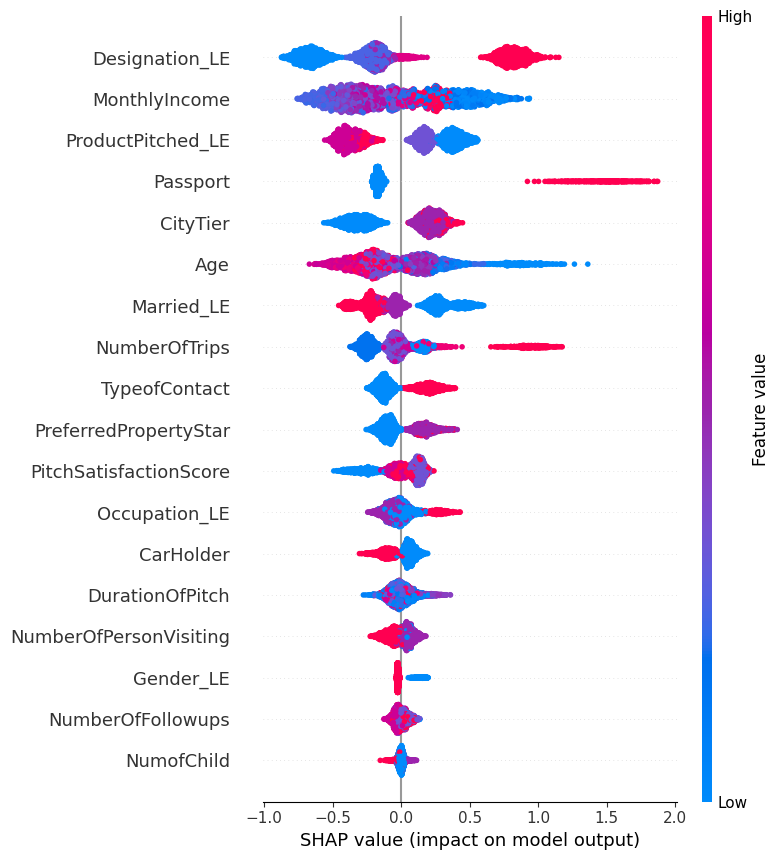

In [ ]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt

shap.initjs()
# 基本スコア
explainer = shap.TreeExplainer(model=models[0])

# 学習済みのモデル（例：lgb_model）
# 学習に使った特徴量データ（例：X_train）

# 横軸：SHAP値 (0からの貢献度、右=プラスの影響)
# 縦軸：特徴量 (上にあるほど重要)
# 色：その特徴の値 (赤=大きい値、青=小さい値)

# ① SHAPのexplainerを作成
explainer = shap.TreeExplainer(models[0])

# ② SHAP値を計算（X_trainは学習に使った特徴量データ）
shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))

# ③ summary plotで全体の重要度と分布を見る
shap.summary_plot(shap_values, train.drop("ProdTaken",axis=1))

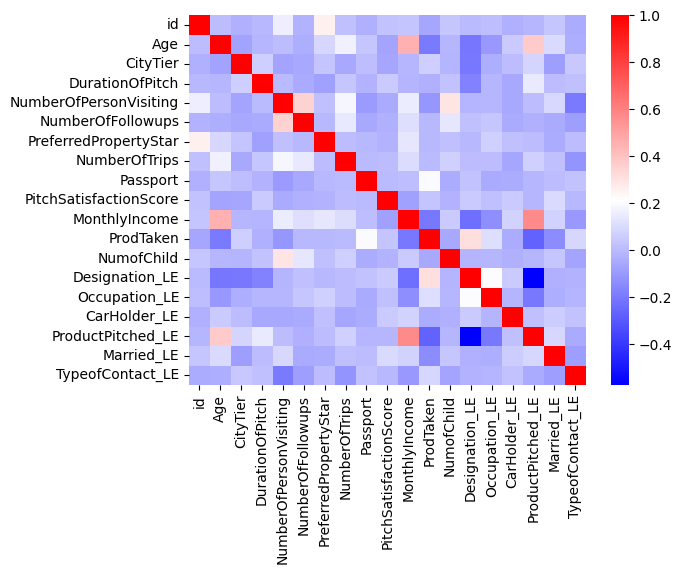

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()

# sns.heatmap(all_df_corr,annot=True,cmap="bwr")
sns.heatmap(all_df_corr,annot=False,cmap="bwr")
plt.show()

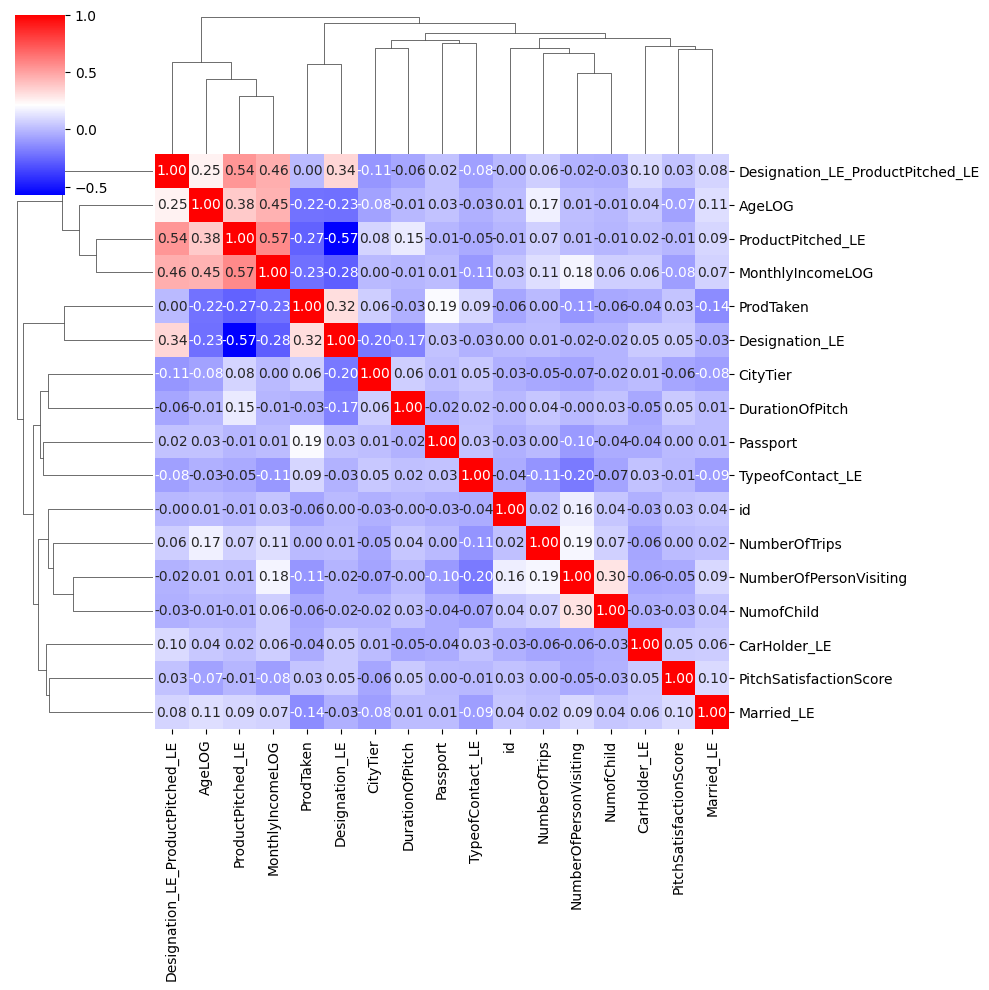

In [ ]:
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [ ]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

def objective(trial):

  lgbm_params = {
      'objective': 'binary',
      "device": "cpu",
      'metric': 'auc',
      # 'metric': 'rmse',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
      'num_leaves': trial.suggest_int('num_leaves', 2, 256), # 20回
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
      # 'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1), # 2回目
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
      # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      # 'max_depth': trial.suggest_int('max_depth', 3, 12),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])


    # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    # models.append(model_lgb)
    # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

  # pred_lgb = []
  # # 予測
  # for model in models:
  #   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

  # pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

  # pred_lgb /= FOLDS
  # score = roc_auc_score(train[TARGET],oof_lgb)

  score = roc_auc_score(train[TARGET],oof_lgb)


  # mse = mean_squared_error(train[TARGET], oof_lgb)
  # rmse = np.sqrt(mse)  # MSEの平方根を取ってRMSEを計算


  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-23 22:55:14,290] A new study created in memory with name: no-name-0c3dc397-40ea-4441-984f-74e39ab25c52
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.858494	valid's auc: 0.824189
[200]	train's auc: 0.863499	valid's auc: 0.825053
#########################
### Fold 2
#########################
[100]	train's auc: 0.845671	valid's auc: 0.860733
[200]	train's auc: 0.851322	valid's auc: 0.860884
#########################
### Fold 3
#########################
[100]	train's auc: 0.865468	valid's auc: 0.806947
[200]	train's auc: 0.868444	valid's auc: 0.810494


[I 2025-05-23 22:55:15,007] Trial 0 finished with value: 0.8309307717965547 and parameters: {'feature_fraction': 0.47027857235761694, 'num_leaves': 118, 'bagging_fraction': 0.8216729149766329, 'bagging_freq': 2, 'lambda_l1': 8.866810416726697, 'lambda_l2': 7.928997700506864, 'min_data_in_leaf': 93}. Best is trial 0 with value: 0.8309307717965547.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.865239	valid's auc: 0.829718
#########################
### Fold 2
#########################
[100]	train's auc: 0.857475	valid's auc: 0.856944
#########################
### Fold 3
#########################
[100]	train's auc: 0.87106	valid's auc: 0.813761
[200]	train's auc: 0.885501	valid's auc: 0.813554
[300]	train's auc: 0.894223	valid's auc: 0.817241
[400]	train's auc: 0.901537	valid's auc: 0.817957


[I 2025-05-23 22:55:15,866] Trial 1 finished with value: 0.8313046729575313 and parameters: {'feature_fraction': 0.410278213052625, 'num_leaves': 89, 'bagging_fraction': 0.6272491775830772, 'bagging_freq': 7, 'lambda_l1': 2.951725302517644, 'lambda_l2': 9.490080323255047, 'min_data_in_leaf': 92}. Best is trial 1 with value: 0.8313046729575313.


[500]	train's auc: 0.908894	valid's auc: 0.817872
#########################
### Fold 1
#########################
[100]	train's auc: 0.853537	valid's auc: 0.826286


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.86145	valid's auc: 0.826588
#########################
### Fold 2
#########################
[100]	train's auc: 0.842232	valid's auc: 0.858195
[200]	train's auc: 0.850602	valid's auc: 0.857754
#########################
### Fold 3
#########################
[100]	train's auc: 0.861082	valid's auc: 0.810749
[200]	train's auc: 0.871067	valid's auc: 0.813384
[300]	train's auc: 0.873156	valid's auc: 0.81503


[I 2025-05-23 22:55:25,333] Trial 2 finished with value: 0.8313053454416338 and parameters: {'feature_fraction': 0.5510503767528263, 'num_leaves': 153, 'bagging_fraction': 0.47306931717876366, 'bagging_freq': 7, 'lambda_l1': 6.3903910986056305, 'lambda_l2': 1.8919082342754652, 'min_data_in_leaf': 96}. Best is trial 2 with value: 0.8313053454416338.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.885107	valid's auc: 0.822208
[200]	train's auc: 0.898882	valid's auc: 0.822842
[300]	train's auc: 0.904462	valid's auc: 0.822298
#########################
### Fold 2
#########################
[100]	train's auc: 0.881059	valid's auc: 0.854721
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:26,106] Trial 3 finished with value: 0.8274600813436772 and parameters: {'feature_fraction': 0.6302747632897231, 'num_leaves': 141, 'bagging_fraction': 0.9510923261468888, 'bagging_freq': 1, 'lambda_l1': 4.427073679976076, 'lambda_l2': 7.927854935410063, 'min_data_in_leaf': 69}. Best is trial 2 with value: 0.8313053454416338.


[100]	train's auc: 0.888566	valid's auc: 0.810743
[200]	train's auc: 0.902941	valid's auc: 0.811222


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.858058	valid's auc: 0.82396
[200]	train's auc: 0.866701	valid's auc: 0.823827
#########################
### Fold 2
#########################
[100]	train's auc: 0.847148	valid's auc: 0.85602
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:26,714] Trial 4 finished with value: 0.8269775740001507 and parameters: {'feature_fraction': 0.9093131428472672, 'num_leaves': 68, 'bagging_fraction': 0.5835296405971037, 'bagging_freq': 6, 'lambda_l1': 8.062303126613227, 'lambda_l2': 6.722108090550263, 'min_data_in_leaf': 74}. Best is trial 2 with value: 0.8313053454416338.


[100]	train's auc: 0.863326	valid's auc: 0.80644
#########################
### Fold 1
#########################
[100]	train's auc: 0.849248	valid's auc: 0.821398


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.854194	valid's auc: 0.824618
[300]	train's auc: 0.856671	valid's auc: 0.825857
#########################
### Fold 2
#########################
[100]	train's auc: 0.834558	valid's auc: 0.856379
[200]	train's auc: 0.841498	valid's auc: 0.859083
[300]	train's auc: 0.847607	valid's auc: 0.861204
[400]	train's auc: 0.849816	valid's auc: 0.861959
#########################
### Fold 3
#########################
[100]	train's auc: 0.856135	valid's auc: 0.807603


[I 2025-05-23 22:55:27,759] Trial 5 finished with value: 0.8318668696672011 and parameters: {'feature_fraction': 0.4892803565530008, 'num_leaves': 66, 'bagging_fraction': 0.47117590871181975, 'bagging_freq': 4, 'lambda_l1': 9.685672812181542, 'lambda_l2': 8.079852211254806, 'min_data_in_leaf': 38}. Best is trial 5 with value: 0.8318668696672011.


[200]	train's auc: 0.862258	valid's auc: 0.809577
[300]	train's auc: 0.8649	valid's auc: 0.812407
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.874341	valid's auc: 0.824776
[200]	train's auc: 0.877684	valid's auc: 0.826298
#########################
### Fold 2
#########################
[100]	train's auc: 0.867292	valid's auc: 0.858074
#########################
### Fold 3
#########################
[100]	train's auc: 0.877358	valid's auc: 0.81554


[I 2025-05-23 22:55:28,427] Trial 6 finished with value: 0.8298437012449026 and parameters: {'feature_fraction': 0.4290100582682084, 'num_leaves': 224, 'bagging_fraction': 0.9800176852871282, 'bagging_freq': 2, 'lambda_l1': 6.573475136355986, 'lambda_l2': 2.6873318065642566, 'min_data_in_leaf': 22}. Best is trial 5 with value: 0.8318668696672011.


[200]	train's auc: 0.882446	valid's auc: 0.816651
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.86314	valid's auc: 0.823241
[200]	train's auc: 0.864166	valid's auc: 0.823011
#########################
### Fold 2
#########################
[100]	train's auc: 0.854165	valid's auc: 0.858394
[200]	train's auc: 0.858759	valid's auc: 0.859754
#########################
### Fold 3
#########################
[100]	train's auc: 0.868472	valid's auc: 0.806887


[I 2025-05-23 22:55:29,272] Trial 7 finished with value: 0.8306483284735149 and parameters: {'feature_fraction': 0.6965812609701174, 'num_leaves': 124, 'bagging_fraction': 0.8352582702580358, 'bagging_freq': 3, 'lambda_l1': 9.9124539929173, 'lambda_l2': 6.332234345518537, 'min_data_in_leaf': 38}. Best is trial 5 with value: 0.8318668696672011.


[200]	train's auc: 0.87443	valid's auc: 0.811575
[300]	train's auc: 0.877127	valid's auc: 0.812437
[400]	train's auc: 0.877375	valid's auc: 0.812674
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.895998	valid's auc: 0.820123
#########################
### Fold 2
#########################
[100]	train's auc: 0.898629	valid's auc: 0.849591
#########################
### Fold 3
#########################
[100]	train's auc: 0.900734	valid's auc: 0.807974


[I 2025-05-23 22:55:30,174] Trial 8 finished with value: 0.8256497541398122 and parameters: {'feature_fraction': 0.9645785932858161, 'num_leaves': 84, 'bagging_fraction': 0.6173500565284545, 'bagging_freq': 7, 'lambda_l1': 1.506220304483326, 'lambda_l2': 9.113061066317186, 'min_data_in_leaf': 51}. Best is trial 5 with value: 0.8318668696672011.


[200]	train's auc: 0.932008	valid's auc: 0.805963
#########################
### Fold 1
#########################
[100]	train's auc: 0.861717	valid's auc: 0.822754
#########################
### Fold 2
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.852933	valid's auc: 0.85454
[200]	train's auc: 0.85765	valid's auc: 0.855506
#########################
### Fold 3
#########################
[100]	train's auc: 0.870959	valid's auc: 0.809352


[I 2025-05-23 22:55:30,710] Trial 9 finished with value: 0.8282499139220348 and parameters: {'feature_fraction': 0.9168982346633602, 'num_leaves': 183, 'bagging_fraction': 0.7656830827002284, 'bagging_freq': 3, 'lambda_l1': 9.73856898588278, 'lambda_l2': 1.0441804594684845, 'min_data_in_leaf': 69}. Best is trial 5 with value: 0.8318668696672011.


[200]	train's auc: 0.871397	valid's auc: 0.809832
#########################
### Fold 1
#########################
[100]	train's auc: 0.853385	valid's auc: 0.823422


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.865829	valid's auc: 0.824117
#########################
### Fold 2
#########################
[100]	train's auc: 0.842815	valid's auc: 0.858213
#########################
### Fold 3
#########################
[100]	train's auc: 0.863705	valid's auc: 0.809036
[200]	train's auc: 0.873115	valid's auc: 0.811441


[I 2025-05-23 22:55:31,366] Trial 10 finished with value: 0.8291977802644745 and parameters: {'feature_fraction': 0.7958046397680866, 'num_leaves': 4, 'bagging_fraction': 0.4191277569707914, 'bagging_freq': 5, 'lambda_l1': 5.13353170614043, 'lambda_l2': 4.236487488493048, 'min_data_in_leaf': 13}. Best is trial 5 with value: 0.8318668696672011.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.859271	valid's auc: 0.821271
[200]	train's auc: 0.869682	valid's auc: 0.823392
[300]	train's auc: 0.873088	valid's auc: 0.823773
#########################
### Fold 2
#########################
[100]	train's auc: 0.848644	valid's auc: 0.856026


[I 2025-05-23 22:55:32,096] Trial 11 finished with value: 0.8278763490031096 and parameters: {'feature_fraction': 0.5504722025206561, 'num_leaves': 32, 'bagging_fraction': 0.40922172155738934, 'bagging_freq': 5, 'lambda_l1': 6.772840095359229, 'lambda_l2': 0.14726236072274634, 'min_data_in_leaf': 35}. Best is trial 5 with value: 0.8318668696672011.


#########################
### Fold 3
#########################
[100]	train's auc: 0.864257	valid's auc: 0.812413
[200]	train's auc: 0.86924	valid's auc: 0.814994


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.859988	valid's auc: 0.821416
[200]	train's auc: 0.867639	valid's auc: 0.823011
#########################
### Fold 2
#########################
[100]	train's auc: 0.846468	valid's auc: 0.856213
[200]	train's auc: 0.860985	valid's auc: 0.855494
#########################
### Fold 3
#########################
[100]	train's auc: 0.868453	valid's auc: 0.815315
[200]	train's auc: 0.874616	valid's auc: 0.817975


[I 2025-05-23 22:55:32,837] Trial 12 finished with value: 0.831533317552373 and parameters: {'feature_fraction': 0.560754625122817, 'num_leaves': 173, 'bagging_fraction': 0.5142473093049356, 'bagging_freq': 4, 'lambda_l1': 6.860781006199174, 'lambda_l2': 3.6860209221079776, 'min_data_in_leaf': 48}. Best is trial 5 with value: 0.8318668696672011.


[300]	train's auc: 0.875069	valid's auc: 0.818413
#########################
### Fold 1
#########################
[100]	train's auc: 0.857156	valid's auc: 0.81996


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.865925	valid's auc: 0.822449
#########################
### Fold 2
#########################
[100]	train's auc: 0.844584	valid's auc: 0.85631
[200]	train's auc: 0.855385	valid's auc: 0.857609
#########################
### Fold 3
#########################
[100]	train's auc: 0.865795	valid's auc: 0.81005
[200]	train's auc: 0.870761	valid's auc: 0.811326


[I 2025-05-23 22:55:33,670] Trial 13 finished with value: 0.8296093405351898 and parameters: {'feature_fraction': 0.5724944578342401, 'num_leaves': 246, 'bagging_fraction': 0.5218127994007979, 'bagging_freq': 4, 'lambda_l1': 7.868529097881106, 'lambda_l2': 4.150893742469795, 'min_data_in_leaf': 51}. Best is trial 5 with value: 0.8318668696672011.


[300]	train's auc: 0.874331	valid's auc: 0.813676
[400]	train's auc: 0.876633	valid's auc: 0.814726
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.868201	valid's auc: 0.819942
[200]	train's auc: 0.882283	valid's auc: 0.819344
#########################
### Fold 2
#########################
[100]	train's auc: 0.859947	valid's auc: 0.857234
#########################
### Fold 3
#########################
[100]	train's auc: 0.878122	valid's auc: 0.815006
[200]	train's auc: 0.888356	valid's auc: 0.817241
[300]	train's auc: 0.896453	valid's auc: 0.820672


[I 2025-05-23 22:55:34,725] Trial 14 finished with value: 0.8295205726336629 and parameters: {'feature_fraction': 0.5094008998133707, 'num_leaves': 188, 'bagging_fraction': 0.5209395684958936, 'bagging_freq': 4, 'lambda_l1': 4.848775647049762, 'lambda_l2': 5.49351569037482, 'min_data_in_leaf': 36}. Best is trial 5 with value: 0.8318668696672011.


[400]	train's auc: 0.904	valid's auc: 0.82174
[500]	train's auc: 0.910096	valid's auc: 0.822166
[600]	train's auc: 0.913889	valid's auc: 0.820775


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.969015	valid's auc: 0.813132
#########################
### Fold 2
#########################
[100]	train's auc: 0.969795	valid's auc: 0.834721
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:38,328] Trial 15 finished with value: 0.8198246968441666 and parameters: {'feature_fraction': 0.6738820513306144, 'num_leaves': 44, 'bagging_fraction': 0.6852346546750625, 'bagging_freq': 5, 'lambda_l1': 0.38005314419521774, 'lambda_l2': 3.04892722035004, 'min_data_in_leaf': 24}. Best is trial 5 with value: 0.8318668696672011.


[100]	train's auc: 0.966275	valid's auc: 0.803662
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.856397	valid's auc: 0.824038
[200]	train's auc: 0.862754	valid's auc: 0.826208
[300]	train's auc: 0.865987	valid's auc: 0.827621
#########################
### Fold 2
#########################
[100]	train's auc: 0.844015	valid's auc: 0.859301
#########################
### Fold 3
#########################
[100]	train's auc: 0.864419	valid's auc: 0.807111
[200]	train's auc: 0.869997	valid's auc: 0.810901
[300]	train's auc: 0.874683	valid's auc: 0.812036


[I 2025-05-23 22:55:39,264] Trial 16 finished with value: 0.8290518512142374 and parameters: {'feature_fraction': 0.621928106600609, 'num_leaves': 172, 'bagging_fraction': 0.5227886700034061, 'bagging_freq': 3, 'lambda_l1': 8.066623418175256, 'lambda_l2': 4.660865807815339, 'min_data_in_leaf': 58}. Best is trial 5 with value: 0.8318668696672011.


[400]	train's auc: 0.878515	valid's auc: 0.813087
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.91168	valid's auc: 0.820727
#########################
### Fold 2
#########################
[100]	train's auc: 0.90824	valid's auc: 0.853101
[200]	train's auc: 0.934201	valid's auc: 0.847996
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:40,131] Trial 17 finished with value: 0.8292791508408741 and parameters: {'feature_fraction': 0.7867546006558469, 'num_leaves': 209, 'bagging_fraction': 0.7029302211145672, 'bagging_freq': 4, 'lambda_l1': 3.766837549505833, 'lambda_l2': 7.621459971788497, 'min_data_in_leaf': 5}. Best is trial 5 with value: 0.8318668696672011.


[100]	train's auc: 0.91156	valid's auc: 0.808095
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.858165	valid's auc: 0.823948
[200]	train's auc: 0.866032	valid's auc: 0.826389
#########################
### Fold 2
#########################
[100]	train's auc: 0.849117	valid's auc: 0.856358
[200]	train's auc: 0.858672	valid's auc: 0.85657
#########################
### Fold 3
#########################
[100]	train's auc: 0.8623	valid's auc: 0.814818


[I 2025-05-23 22:55:40,874] Trial 18 finished with value: 0.8331028954475516 and parameters: {'feature_fraction': 0.480504729283548, 'num_leaves': 101, 'bagging_fraction': 0.45305578659905, 'bagging_freq': 6, 'lambda_l1': 5.823355384805122, 'lambda_l2': 5.726410326017227, 'min_data_in_leaf': 44}. Best is trial 18 with value: 0.8331028954475516.


[200]	train's auc: 0.872284	valid's auc: 0.817599
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.88088	valid's auc: 0.820757
[200]	train's auc: 0.900139	valid's auc: 0.821797
#########################
### Fold 2
#########################
[100]	train's auc: 0.879101	valid's auc: 0.85347
[200]	train's auc: 0.899624	valid's auc: 0.848981
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:41,724] Trial 19 finished with value: 0.8326846103358116 and parameters: {'feature_fraction': 0.47594707993703206, 'num_leaves': 113, 'bagging_fraction': 0.46829070707831877, 'bagging_freq': 6, 'lambda_l1': 2.6772246776279713, 'lambda_l2': 5.698582875568366, 'min_data_in_leaf': 25}. Best is trial 18 with value: 0.8331028954475516.


[100]	train's auc: 0.884481	valid's auc: 0.818212
[200]	train's auc: 0.908072	valid's auc: 0.820155
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.911687	valid's auc: 0.825724
#########################
### Fold 2
#########################
[100]	train's auc: 0.914539	valid's auc: 0.843833
#########################
### Fold 3
#########################
[100]	train's auc: 0.915969	valid's auc: 0.810852


[I 2025-05-23 22:55:42,460] Trial 20 finished with value: 0.8269194041252864 and parameters: {'feature_fraction': 0.7947331435478799, 'num_leaves': 106, 'bagging_fraction': 0.5848106266228199, 'bagging_freq': 6, 'lambda_l1': 2.1781604113664352, 'lambda_l2': 6.105899347013368, 'min_data_in_leaf': 18}. Best is trial 18 with value: 0.8331028954475516.


[200]	train's auc: 0.948957	valid's auc: 0.81104
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.89842	valid's auc: 0.820909
#########################
### Fold 2
#########################
[100]	train's auc: 0.898144	valid's auc: 0.851621
#########################
### Fold 3
#########################
[100]	train's auc: 0.901421	valid's auc: 0.820095


[I 2025-05-23 22:55:43,149] Trial 21 finished with value: 0.8292791508408741 and parameters: {'feature_fraction': 0.4685466067319679, 'num_leaves': 53, 'bagging_fraction': 0.4513908947165414, 'bagging_freq': 6, 'lambda_l1': 0.4500366195172689, 'lambda_l2': 7.108113522488885, 'min_data_in_leaf': 30}. Best is trial 18 with value: 0.8331028954475516.


[200]	train's auc: 0.933144	valid's auc: 0.815486
#########################
### Fold 1
#########################
[100]	train's auc: 0.860276	valid's auc: 0.821887


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.869644	valid's auc: 0.82602
[300]	train's auc: 0.87628	valid's auc: 0.823519
#########################
### Fold 2
#########################
[100]	train's auc: 0.851187	valid's auc: 0.852685
[200]	train's auc: 0.862376	valid's auc: 0.852268
[300]	train's auc: 0.869429	valid's auc: 0.856098
[400]	train's auc: 0.877741	valid's auc: 0.855023
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:44,106] Trial 22 finished with value: 0.8320847545164032 and parameters: {'feature_fraction': 0.4816345606091615, 'num_leaves': 79, 'bagging_fraction': 0.48482853516798996, 'bagging_freq': 6, 'lambda_l1': 5.724283307803062, 'lambda_l2': 5.3276873481663785, 'min_data_in_leaf': 42}. Best is trial 18 with value: 0.8331028954475516.


[100]	train's auc: 0.866867	valid's auc: 0.815868
[200]	train's auc: 0.878172	valid's auc: 0.817957


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.855435	valid's auc: 0.823416
[200]	train's auc: 0.8646	valid's auc: 0.826008
[300]	train's auc: 0.870596	valid's auc: 0.825827
#########################
### Fold 2
#########################
[100]	train's auc: 0.842607	valid's auc: 0.856968
[200]	train's auc: 0.852931	valid's auc: 0.856219
#########################
### Fold 3
#########################
[100]	train's auc: 0.861542	valid's auc: 0.815224
[200]	train's auc: 0.87081	valid's auc: 0.815449
[300]	train's auc: 0.875654	valid's auc: 0.817599
[400]	train's auc: 0.881702	valid's auc: 0.820283
[500]	train's auc: 0.884932	valid's auc: 0.822894


[I 2025-05-23 22:55:45,180] Trial 23 finished with value: 0.8325413712219843 and parameters: {'feature_fraction': 0.4168644088111567, 'num_leaves': 98, 'bagging_fraction': 0.4048968054235994, 'bagging_freq': 6, 'lambda_l1': 5.620280807541148, 'lambda_l2': 5.271011253351733, 'min_data_in_leaf': 44}. Best is trial 18 with value: 0.8331028954475516.


[600]	train's auc: 0.88789	valid's auc: 0.824054
#########################
### Fold 1
#########################
[100]	train's auc: 0.860985	valid's auc: 0.823615


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.872271	valid's auc: 0.826105
[300]	train's auc: 0.879861	valid's auc: 0.828461
[400]	train's auc: 0.885324	valid's auc: 0.826927
#########################
### Fold 2
#########################
[100]	train's auc: 0.848994	valid's auc: 0.857252
[200]	train's auc: 0.863164	valid's auc: 0.852999
#########################
### Fold 3
#########################
[100]	train's auc: 0.867216	valid's auc: 0.817058


[I 2025-05-23 22:55:46,095] Trial 24 finished with value: 0.8341062417284455 and parameters: {'feature_fraction': 0.41007277941849635, 'num_leaves': 143, 'bagging_fraction': 0.4056068234981311, 'bagging_freq': 6, 'lambda_l1': 3.5255646301896215, 'lambda_l2': 5.06243069102702, 'min_data_in_leaf': 63}. Best is trial 24 with value: 0.8341062417284455.


[200]	train's auc: 0.88122	valid's auc: 0.820107
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.867971	valid's auc: 0.823126
[200]	train's auc: 0.882349	valid's auc: 0.824359
#########################
### Fold 2
#########################
[100]	train's auc: 0.86254	valid's auc: 0.859627
[200]	train's auc: 0.879988	valid's auc: 0.858751
#########################
### Fold 3
#########################
[100]	train's auc: 0.871817	valid's auc: 0.81333
[200]	train's auc: 0.887112	valid's auc: 0.819512
[300]	train's auc: 0.895675	valid's auc: 0.821048


[I 2025-05-23 22:55:47,128] Trial 25 finished with value: 0.8327666533963137 and parameters: {'feature_fraction': 0.40506845124344865, 'num_leaves': 154, 'bagging_fraction': 0.5713778164208194, 'bagging_freq': 5, 'lambda_l1': 3.6953128541438076, 'lambda_l2': 5.973331169928623, 'min_data_in_leaf': 60}. Best is trial 24 with value: 0.8341062417284455.


[400]	train's auc: 0.903154	valid's auc: 0.821419
[500]	train's auc: 0.909539	valid's auc: 0.820544
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.870109	valid's auc: 0.824177
#########################
### Fold 2
#########################
[100]	train's auc: 0.864319	valid's auc: 0.858038
#########################
### Fold 3
#########################
[100]	train's auc: 0.875323	valid's auc: 0.817131
[200]	train's auc: 0.889825	valid's auc: 0.820605


[I 2025-05-23 22:55:47,802] Trial 26 finished with value: 0.8312834897083032 and parameters: {'feature_fraction': 0.4291979769458116, 'num_leaves': 140, 'bagging_fraction': 0.5553898682136359, 'bagging_freq': 5, 'lambda_l1': 3.7266761751137976, 'lambda_l2': 3.2314886228587274, 'min_data_in_leaf': 59}. Best is trial 24 with value: 0.8341062417284455.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.870967	valid's auc: 0.826492
[200]	train's auc: 0.8871	valid's auc: 0.827718
#########################
### Fold 2
#########################
[100]	train's auc: 0.867233	valid's auc: 0.855579
#########################
### Fold 3
#########################
[100]	train's auc: 0.875133	valid's auc: 0.810354
[200]	train's auc: 0.891861	valid's auc: 0.817058
[300]	train's auc: 0.899356	valid's auc: 0.819481


[I 2025-05-23 22:55:51,443] Trial 27 finished with value: 0.8286164177578842 and parameters: {'feature_fraction': 0.5211951803231629, 'num_leaves': 160, 'bagging_fraction': 0.6325412930520735, 'bagging_freq': 5, 'lambda_l1': 4.021064979952011, 'lambda_l2': 4.85317478493218, 'min_data_in_leaf': 76}. Best is trial 24 with value: 0.8341062417284455.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.862164	valid's auc: 0.82744
[200]	train's auc: 0.875433	valid's auc: 0.829053
#########################
### Fold 2
#########################
[100]	train's auc: 0.852053	valid's auc: 0.860135
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:52,196] Trial 28 finished with value: 0.835053771828834 and parameters: {'feature_fraction': 0.40338538741469376, 'num_leaves': 133, 'bagging_fraction': 0.44650127139645795, 'bagging_freq': 7, 'lambda_l1': 3.107900276611632, 'lambda_l2': 7.001696815025252, 'min_data_in_leaf': 63}. Best is trial 28 with value: 0.835053771828834.


[100]	train's auc: 0.868938	valid's auc: 0.813852
[200]	train's auc: 0.883852	valid's auc: 0.819828
[300]	train's auc: 0.890358	valid's auc: 0.819184


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.862278	valid's auc: 0.827948
[200]	train's auc: 0.876159	valid's auc: 0.829162
#########################
### Fold 2
#########################
[100]	train's auc: 0.853312	valid's auc: 0.858751
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:52,879] Trial 29 finished with value: 0.8362803828317499 and parameters: {'feature_fraction': 0.45705463013508557, 'num_leaves': 120, 'bagging_fraction': 0.44209794224057836, 'bagging_freq': 7, 'lambda_l1': 2.2276613705975654, 'lambda_l2': 8.584681328939595, 'min_data_in_leaf': 86}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.867662	valid's auc: 0.817125
[200]	train's auc: 0.882991	valid's auc: 0.821212
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.898249	valid's auc: 0.82144
#########################
### Fold 2
#########################
[100]	train's auc: 0.899151	valid's auc: 0.848473
#########################
### Fold 3
#########################
[100]	train's auc: 0.901273	valid's auc: 0.811374


[I 2025-05-23 22:55:53,530] Trial 30 finished with value: 0.8263185395797243 and parameters: {'feature_fraction': 0.6144999835106199, 'num_leaves': 131, 'bagging_fraction': 0.8550090265852675, 'bagging_freq': 7, 'lambda_l1': 1.2345480560392652, 'lambda_l2': 8.82085336081849, 'min_data_in_leaf': 85}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.860926	valid's auc: 0.825893
[200]	train's auc: 0.874499	valid's auc: 0.82489
#########################
### Fold 2
#########################
[100]	train's auc: 0.854665	valid's auc: 0.858141
#########################
### Fold 3
#########################
[100]	train's auc: 0.868263	valid's auc: 0.812959
[200]	train's auc: 0.883264	valid's auc: 0.818121
[300]	train's auc: 0.890075	valid's auc: 0.817058


[I 2025-05-23 22:55:54,294] Trial 31 finished with value: 0.8339757798125652 and parameters: {'feature_fraction': 0.45807170882012804, 'num_leaves': 121, 'bagging_fraction': 0.43797109164769804, 'bagging_freq': 7, 'lambda_l1': 2.885642414366064, 'lambda_l2': 9.873485332832669, 'min_data_in_leaf': 65}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.859164	valid's auc: 0.827331
[200]	train's auc: 0.871251	valid's auc: 0.827059
#########################
### Fold 2
#########################
[100]	train's auc: 0.847422	valid's auc: 0.860086
#########################
### Fold 3
#########################
[100]	train's auc: 0.864222	valid's auc: 0.813676


[I 2025-05-23 22:55:54,999] Trial 32 finished with value: 0.8339804872012826 and parameters: {'feature_fraction': 0.44582558315157866, 'num_leaves': 122, 'bagging_fraction': 0.4340505173304712, 'bagging_freq': 7, 'lambda_l1': 2.944548989232467, 'lambda_l2': 9.955465153341418, 'min_data_in_leaf': 86}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.877391	valid's auc: 0.816445
[300]	train's auc: 0.884095	valid's auc: 0.814398
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.859068	valid's auc: 0.825718
[200]	train's auc: 0.872561	valid's auc: 0.826425
#########################
### Fold 2
#########################
[100]	train's auc: 0.849913	valid's auc: 0.857192
#########################
### Fold 3
#########################
[100]	train's auc: 0.864719	valid's auc: 0.812067


[I 2025-05-23 22:55:55,721] Trial 33 finished with value: 0.8326045847276169 and parameters: {'feature_fraction': 0.4401511558111197, 'num_leaves': 137, 'bagging_fraction': 0.4015148240802163, 'bagging_freq': 7, 'lambda_l1': 2.066912586787067, 'lambda_l2': 8.486712136268586, 'min_data_in_leaf': 86}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.880603	valid's auc: 0.818413
[300]	train's auc: 0.888385	valid's auc: 0.816208
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.855725	valid's auc: 0.827464
[200]	train's auc: 0.868355	valid's auc: 0.828951
#########################
### Fold 2
#########################
[100]	train's auc: 0.844352	valid's auc: 0.858092
#########################
### Fold 3
#########################
[100]	train's auc: 0.861965	valid's auc: 0.81271


[I 2025-05-23 22:55:56,476] Trial 34 finished with value: 0.8336946814577303 and parameters: {'feature_fraction': 0.40387285898556513, 'num_leaves': 151, 'bagging_fraction': 0.4405327673714225, 'bagging_freq': 7, 'lambda_l1': 2.969675893290621, 'lambda_l2': 9.517113295078829, 'min_data_in_leaf': 98}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.874719	valid's auc: 0.817417
[300]	train's auc: 0.880001	valid's auc: 0.817319
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.873352	valid's auc: 0.828298
#########################
### Fold 2
#########################
[100]	train's auc: 0.871413	valid's auc: 0.856902
[200]	train's auc: 0.894661	valid's auc: 0.851512
#########################
### Fold 3
#########################
[100]	train's auc: 0.876598	valid's auc: 0.811781


[I 2025-05-23 22:55:57,290] Trial 35 finished with value: 0.8311795909144709 and parameters: {'feature_fraction': 0.5209599100156009, 'num_leaves': 121, 'bagging_fraction': 0.4956808695202633, 'bagging_freq': 7, 'lambda_l1': 1.1519049856023644, 'lambda_l2': 7.091817864285634, 'min_data_in_leaf': 82}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.899028	valid's auc: 0.812394
[300]	train's auc: 0.911797	valid's auc: 0.813973
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.858444	valid's auc: 0.828346
[200]	train's auc: 0.871264	valid's auc: 0.828226
#########################
### Fold 2
#########################
[100]	train's auc: 0.851701	valid's auc: 0.857742
[200]	train's auc: 0.867721	valid's auc: 0.857355
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:58,056] Trial 36 finished with value: 0.8345823604729984 and parameters: {'feature_fraction': 0.4485368497757733, 'num_leaves': 97, 'bagging_fraction': 0.4876706876060213, 'bagging_freq': 7, 'lambda_l1': 3.2756964964826585, 'lambda_l2': 8.379725664753842, 'min_data_in_leaf': 93}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.867174	valid's auc: 0.812334
[200]	train's auc: 0.881078	valid's auc: 0.816336
[300]	train's auc: 0.886442	valid's auc: 0.817344


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.87491	valid's auc: 0.829132
[200]	train's auc: 0.894258	valid's auc: 0.833501
#########################
### Fold 2
#########################
[100]	train's auc: 0.871778	valid's auc: 0.858872
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:58,790] Trial 37 finished with value: 0.8319280657205264 and parameters: {'feature_fraction': 0.7474553515212106, 'num_leaves': 97, 'bagging_fraction': 0.5499376386865119, 'bagging_freq': 7, 'lambda_l1': 1.9972109050778049, 'lambda_l2': 7.611108680267458, 'min_data_in_leaf': 91}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.878228	valid's auc: 0.81138
[200]	train's auc: 0.898249	valid's auc: 0.812467
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.860499	valid's auc: 0.826685
[200]	train's auc: 0.871622	valid's auc: 0.826232
#########################
### Fold 2
#########################
[100]	train's auc: 0.852592	valid's auc: 0.853929
#########################
### Fold 3
#########################
[100]	train's auc: 0.866243	valid's auc: 0.81067
[200]	train's auc: 0.881669	valid's auc: 0.814629
[300]	train's auc: 0.886296	valid's auc: 0.814441


[I 2025-05-23 22:55:59,648] Trial 38 finished with value: 0.8307888776509323 and parameters: {'feature_fraction': 0.5788894628507594, 'num_leaves': 73, 'bagging_fraction': 0.49449430086862506, 'bagging_freq': 6, 'lambda_l1': 4.517764261285002, 'lambda_l2': 8.051825094465409, 'min_data_in_leaf': 78}. Best is trial 29 with value: 0.8362803828317499.


[400]	train's auc: 0.891846	valid's auc: 0.817162
#########################
### Fold 1
#########################
[100]	train's auc: 0.883164	valid's auc: 0.822733


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.902833	valid's auc: 0.822963
#########################
### Fold 2
#########################
[100]	train's auc: 0.881856	valid's auc: 0.854201
#########################
### Fold 3
#########################
[100]	train's auc: 0.888719	valid's auc: 0.812237
[200]	train's auc: 0.907196	valid's auc: 0.813129
[300]	train's auc: 0.91595	valid's auc: 0.812686


[I 2025-05-23 22:56:00,499] Trial 39 finished with value: 0.8282583199733159 and parameters: {'feature_fraction': 0.5215861884434758, 'num_leaves': 194, 'bagging_fraction': 0.9004873355270997, 'bagging_freq': 1, 'lambda_l1': 3.367474242579695, 'lambda_l2': 6.634637913820147, 'min_data_in_leaf': 91}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.863228	valid's auc: 0.824812
#########################
### Fold 2
#########################
[100]	train's auc: 0.85589	valid's auc: 0.857011
#########################
### Fold 3
#########################
[100]	train's auc: 0.869619	valid's auc: 0.811781
[200]	train's auc: 0.882603	valid's auc: 0.812085
[300]	train's auc: 0.888352	valid's auc: 0.814805


[I 2025-05-23 22:56:04,206] Trial 40 finished with value: 0.8282320930933194 and parameters: {'feature_fraction': 0.4003313544769424, 'num_leaves': 167, 'bagging_fraction': 0.6225062402628808, 'bagging_freq': 7, 'lambda_l1': 4.365994640054209, 'lambda_l2': 8.547581136252862, 'min_data_in_leaf': 70}. Best is trial 29 with value: 0.8362803828317499.


[400]	train's auc: 0.894328	valid's auc: 0.8167
[500]	train's auc: 0.900315	valid's auc: 0.816718


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.859641	valid's auc: 0.828679
[200]	train's auc: 0.872471	valid's auc: 0.829537
#########################
### Fold 2
#########################
[100]	train's auc: 0.848132	valid's auc: 0.85947
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:04,936] Trial 41 finished with value: 0.8350820161611381 and parameters: {'feature_fraction': 0.448128954307543, 'num_leaves': 146, 'bagging_fraction': 0.4346965534851677, 'bagging_freq': 7, 'lambda_l1': 2.40422586810867, 'lambda_l2': 9.228947765826637, 'min_data_in_leaf': 95}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.863455	valid's auc: 0.813062
[200]	train's auc: 0.878359	valid's auc: 0.817532
[300]	train's auc: 0.885152	valid's auc: 0.818619


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.859458	valid's auc: 0.826945
[200]	train's auc: 0.87361	valid's auc: 0.825682
#########################
### Fold 2
#########################
[100]	train's auc: 0.8515	valid's auc: 0.857228
#########################
### Fold 3
#########################
[100]	train's auc: 0.865849	valid's auc: 0.814022
[200]	train's auc: 0.881719	valid's auc: 0.817453


[I 2025-05-23 22:56:06,210] Trial 42 finished with value: 0.8337168734331121 and parameters: {'feature_fraction': 0.4520968864010434, 'num_leaves': 146, 'bagging_fraction': 0.46485267363921895, 'bagging_freq': 7, 'lambda_l1': 2.3860259531352312, 'lambda_l2': 9.199702693676125, 'min_data_in_leaf': 99}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.887661	valid's auc: 0.818358
#########################
### Fold 1
#########################
[100]	train's auc: 0.866777	valid's auc: 0.829229


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.881845	valid's auc: 0.829954
#########################
### Fold 2
#########################
[100]	train's auc: 0.859864	valid's auc: 0.855234
[200]	train's auc: 0.881532	valid's auc: 0.849627
#########################
### Fold 3
#########################
[100]	train's auc: 0.872586	valid's auc: 0.812334


[I 2025-05-23 22:56:07,490] Trial 43 finished with value: 0.8350604966698588 and parameters: {'feature_fraction': 0.5027744898191268, 'num_leaves': 90, 'bagging_fraction': 0.43323788636740274, 'bagging_freq': 6, 'lambda_l1': 1.664542261222835, 'lambda_l2': 8.273910414490384, 'min_data_in_leaf': 80}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.891547	valid's auc: 0.814951
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.868416	valid's auc: 0.829452
#########################
### Fold 2
#########################
[100]	train's auc: 0.862574	valid's auc: 0.857089
[200]	train's auc: 0.881109	valid's auc: 0.854926
#########################
### Fold 3
#########################
[100]	train's auc: 0.871818	valid's auc: 0.812613
[200]	train's auc: 0.891465	valid's auc: 0.814101


[I 2025-05-23 22:56:08,246] Trial 44 finished with value: 0.83210560152358 and parameters: {'feature_fraction': 0.5079331928964885, 'num_leaves': 83, 'bagging_fraction': 0.49337618472750117, 'bagging_freq': 7, 'lambda_l1': 1.5603443639290622, 'lambda_l2': 8.33838772665331, 'min_data_in_leaf': 94}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.901192	valid's auc: 0.818048
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.867441	valid's auc: 0.823156
#########################
### Fold 2
#########################
[100]	train's auc: 0.859628	valid's auc: 0.858249
#########################
### Fold 3
#########################
[100]	train's auc: 0.872779	valid's auc: 0.813311
[200]	train's auc: 0.892553	valid's auc: 0.816633


[I 2025-05-23 22:56:08,890] Trial 45 finished with value: 0.8319516026641129 and parameters: {'feature_fraction': 0.5434717417334411, 'num_leaves': 111, 'bagging_fraction': 0.42523446687170025, 'bagging_freq': 7, 'lambda_l1': 0.8517065324429067, 'lambda_l2': 8.995570642065063, 'min_data_in_leaf': 82}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.872329	valid's auc: 0.827779
[200]	train's auc: 0.889234	valid's auc: 0.829519
#########################
### Fold 2
#########################
[100]	train's auc: 0.866047	valid's auc: 0.85376
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:09,500] Trial 46 finished with value: 0.8320571826682016 and parameters: {'feature_fraction': 0.49952982897790066, 'num_leaves': 55, 'bagging_fraction': 0.5396508206922758, 'bagging_freq': 6, 'lambda_l1': 1.8320020414497762, 'lambda_l2': 7.485793827927812, 'min_data_in_leaf': 90}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.874183	valid's auc: 0.820411
[200]	train's auc: 0.894722	valid's auc: 0.819342
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.887794	valid's auc: 0.821319
[200]	train's auc: 0.911784	valid's auc: 0.822147
#########################
### Fold 2
#########################
[100]	train's auc: 0.889344	valid's auc: 0.851657
#########################
### Fold 3
#########################
[100]	train's auc: 0.890885	valid's auc: 0.813123


[I 2025-05-23 22:56:10,236] Trial 47 finished with value: 0.828450650426624 and parameters: {'feature_fraction': 0.5847271988101193, 'num_leaves': 86, 'bagging_fraction': 0.7694491956846389, 'bagging_freq': 7, 'lambda_l1': 2.4795290602565263, 'lambda_l2': 8.059581967125169, 'min_data_in_leaf': 72}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.914713	valid's auc: 0.813506
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.872679	valid's auc: 0.825174
[200]	train's auc: 0.893466	valid's auc: 0.826655
#########################
### Fold 2
#########################
[100]	train's auc: 0.870548	valid's auc: 0.853089
#########################
### Fold 3
#########################
[100]	train's auc: 0.88114	valid's auc: 0.817593


[I 2025-05-23 22:56:10,954] Trial 48 finished with value: 0.83265972842402 and parameters: {'feature_fraction': 0.4371791180376162, 'num_leaves': 132, 'bagging_fraction': 0.46962242049984615, 'bagging_freq': 6, 'lambda_l1': 0.09373301416898472, 'lambda_l2': 9.338981655271866, 'min_data_in_leaf': 79}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.905111	valid's auc: 0.817441
#########################
### Fold 1
#########################
[100]	train's auc: 0.875827	valid's auc: 0.830721


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.873616	valid's auc: 0.856443
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:11,504] Trial 49 finished with value: 0.8321288022251153 and parameters: {'feature_fraction': 0.5386196118200486, 'num_leaves': 91, 'bagging_fraction': 0.5920022284822103, 'bagging_freq': 7, 'lambda_l1': 1.5678732623303584, 'lambda_l2': 7.042639158242492, 'min_data_in_leaf': 100}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.878551	valid's auc: 0.813482
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.871478	valid's auc: 0.831126
[200]	train's auc: 0.889965	valid's auc: 0.830957
#########################
### Fold 2
#########################
[100]	train's auc: 0.863753	valid's auc: 0.852691
#########################
### Fold 3
#########################
[100]	train's auc: 0.876838	valid's auc: 0.81288


[I 2025-05-23 22:56:12,187] Trial 50 finished with value: 0.8245122472804743 and parameters: {'feature_fraction': 0.8867819317577077, 'num_leaves': 26, 'bagging_fraction': 0.4361871650581403, 'bagging_freq': 2, 'lambda_l1': 0.8098403185841458, 'lambda_l2': 8.669341250534188, 'min_data_in_leaf': 95}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.895124	valid's auc: 0.813026
#########################
### Fold 1
#########################
[100]	train's auc: 0.866967	valid's auc: 0.823942


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.880447	valid's auc: 0.826878
#########################
### Fold 2
#########################
[100]	train's auc: 0.857923	valid's auc: 0.855911
[200]	train's auc: 0.874158	valid's auc: 0.851579
#########################
### Fold 3
#########################
[100]	train's auc: 0.873399	valid's auc: 0.813761


[I 2025-05-23 22:56:12,976] Trial 51 finished with value: 0.8324573107091748 and parameters: {'feature_fraction': 0.46150873053232483, 'num_leaves': 131, 'bagging_fraction': 0.41265101714215957, 'bagging_freq': 6, 'lambda_l1': 3.26473849968669, 'lambda_l2': 2.082735823120961, 'min_data_in_leaf': 65}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.891479	valid's auc: 0.815425
#########################
### Fold 1
#########################
[100]	train's auc: 0.86236	valid's auc: 0.826123


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.874894	valid's auc: 0.827343
#########################
### Fold 2
#########################
[100]	train's auc: 0.854599	valid's auc: 0.855265
#########################
### Fold 3
#########################
[100]	train's auc: 0.869977	valid's auc: 0.815625
[200]	train's auc: 0.883998	valid's auc: 0.815935


[I 2025-05-23 22:56:13,730] Trial 52 finished with value: 0.8278319650523461 and parameters: {'feature_fraction': 0.42343174463723954, 'num_leaves': 112, 'bagging_fraction': 0.5101097326569876, 'bagging_freq': 6, 'lambda_l1': 3.449274997456781, 'lambda_l2': 8.281909890671987, 'min_data_in_leaf': 67}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.890529	valid's auc: 0.8135
#########################
### Fold 1
#########################
[100]	train's auc: 0.8661	valid's auc: 0.827404


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.882254	valid's auc: 0.827676
#########################
### Fold 2
#########################
[100]	train's auc: 0.861531	valid's auc: 0.856908
#########################
### Fold 3
#########################
[100]	train's auc: 0.872015	valid's auc: 0.815152


[I 2025-05-23 22:56:17,284] Trial 53 finished with value: 0.834040338286403 and parameters: {'feature_fraction': 0.4805649070922209, 'num_leaves': 178, 'bagging_fraction': 0.46070384543194065, 'bagging_freq': 7, 'lambda_l1': 2.533477498522967, 'lambda_l2': 9.559609403311121, 'min_data_in_leaf': 56}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.890084	valid's auc: 0.817568
[300]	train's auc: 0.897572	valid's auc: 0.817896
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.860367	valid's auc: 0.826413
[200]	train's auc: 0.872523	valid's auc: 0.828691
#########################
### Fold 2
#########################
[100]	train's auc: 0.850415	valid's auc: 0.854026
[200]	train's auc: 0.866889	valid's auc: 0.849482
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:18,102] Trial 54 finished with value: 0.8321930244569018 and parameters: {'feature_fraction': 0.4438814830892867, 'num_leaves': 145, 'bagging_fraction': 0.4266184577167425, 'bagging_freq': 6, 'lambda_l1': 3.128412000424267, 'lambda_l2': 6.409552713207584, 'min_data_in_leaf': 88}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.865986	valid's auc: 0.810743
[200]	train's auc: 0.881072	valid's auc: 0.816135


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.857459	valid's auc: 0.826643
[200]	train's auc: 0.869031	valid's auc: 0.827229
#########################
### Fold 2
#########################
[100]	train's auc: 0.850398	valid's auc: 0.85953
#########################
### Fold 3
#########################
[100]	train's auc: 0.866248	valid's auc: 0.810949
[200]	train's auc: 0.878214	valid's auc: 0.816457


[I 2025-05-23 22:56:19,207] Trial 55 finished with value: 0.8333080030988069 and parameters: {'feature_fraction': 0.49258637605374633, 'num_leaves': 66, 'bagging_fraction': 0.4801805846661832, 'bagging_freq': 7, 'lambda_l1': 4.197684658373672, 'lambda_l2': 7.7541666892229415, 'min_data_in_leaf': 74}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.883279	valid's auc: 0.817556
[400]	train's auc: 0.888461	valid's auc: 0.819415


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.858465	valid's auc: 0.825078
[200]	train's auc: 0.868192	valid's auc: 0.824902
#########################
### Fold 2
#########################
[100]	train's auc: 0.84826	valid's auc: 0.858491
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:19,909] Trial 56 finished with value: 0.8320719773184562 and parameters: {'feature_fraction': 0.6536848216172695, 'num_leaves': 158, 'bagging_fraction': 0.45289849868052945, 'bagging_freq': 6, 'lambda_l1': 4.969536579198013, 'lambda_l2': 7.2559400702094115, 'min_data_in_leaf': 81}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.864413	valid's auc: 0.811368
[200]	train's auc: 0.876873	valid's auc: 0.816336


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.866797	valid's auc: 0.823199
[200]	train's auc: 0.881052	valid's auc: 0.827706
#########################
### Fold 2
#########################
[100]	train's auc: 0.858933	valid's auc: 0.857041
[200]	train's auc: 0.875483	valid's auc: 0.857688
#########################
### Fold 3
#########################
[100]	train's auc: 0.871216	valid's auc: 0.813791
[200]	train's auc: 0.890007	valid's auc: 0.81687


[I 2025-05-23 22:56:20,711] Trial 57 finished with value: 0.8337733620977201 and parameters: {'feature_fraction': 0.4629427370270085, 'num_leaves': 106, 'bagging_fraction': 0.40710681519263503, 'bagging_freq': 5, 'lambda_l1': 1.7909387391221205, 'lambda_l2': 8.840423465320006, 'min_data_in_leaf': 63}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.870949	valid's auc: 0.825646
#########################
### Fold 2
#########################
[100]	train's auc: 0.865663	valid's auc: 0.857138
#########################
### Fold 3
#########################
[100]	train's auc: 0.875299	valid's auc: 0.812473


[I 2025-05-23 22:56:21,508] Trial 58 finished with value: 0.8305306437555815 and parameters: {'feature_fraction': 0.4204273800163275, 'num_leaves': 166, 'bagging_fraction': 0.6517697623446567, 'bagging_freq': 7, 'lambda_l1': 2.324341284245957, 'lambda_l2': 8.028563687551008, 'min_data_in_leaf': 95}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.892806	valid's auc: 0.814903
[300]	train's auc: 0.902225	valid's auc: 0.817429
[400]	train's auc: 0.911143	valid's auc: 0.816488


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.866094	valid's auc: 0.827495
[200]	train's auc: 0.881046	valid's auc: 0.827591
#########################
### Fold 2
#########################
[100]	train's auc: 0.860868	valid's auc: 0.857452
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:22,289] Trial 59 finished with value: 0.8308628509022046 and parameters: {'feature_fraction': 0.42953303993912556, 'num_leaves': 195, 'bagging_fraction': 0.5322274162760683, 'bagging_freq': 6, 'lambda_l1': 2.74624245509693, 'lambda_l2': 6.716804442976147, 'min_data_in_leaf': 75}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.872912	valid's auc: 0.816597
[200]	train's auc: 0.890497	valid's auc: 0.818346


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.867353	valid's auc: 0.82489
#########################
### Fold 2
#########################
[100]	train's auc: 0.85903	valid's auc: 0.859397
[200]	train's auc: 0.876899	valid's auc: 0.857585
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:23,025] Trial 60 finished with value: 0.8351997008790712 and parameters: {'feature_fraction': 0.4005559088334328, 'num_leaves': 92, 'bagging_fraction': 0.5038753530134158, 'bagging_freq': 5, 'lambda_l1': 3.907732884338815, 'lambda_l2': 4.0744753948206345, 'min_data_in_leaf': 52}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.872663	valid's auc: 0.816749
[200]	train's auc: 0.887223	valid's auc: 0.819821


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.866373	valid's auc: 0.826165
[200]	train's auc: 0.881239	valid's auc: 0.826769
[300]	train's auc: 0.889942	valid's auc: 0.82573
#########################
### Fold 2
#########################
[100]	train's auc: 0.857921	valid's auc: 0.861011
#########################
### Fold 3
#########################
[100]	train's auc: 0.872027	valid's auc: 0.814362
[200]	train's auc: 0.886619	valid's auc: 0.820168


[I 2025-05-23 22:56:23,848] Trial 61 finished with value: 0.8350672215108836 and parameters: {'feature_fraction': 0.4052910840821733, 'num_leaves': 75, 'bagging_fraction': 0.5112783335349782, 'bagging_freq': 5, 'lambda_l1': 3.9422764223866658, 'lambda_l2': 4.162290358667264, 'min_data_in_leaf': 54}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.864029	valid's auc: 0.824848
[200]	train's auc: 0.877735	valid's auc: 0.826292
[300]	train's auc: 0.884998	valid's auc: 0.824649
#########################
### Fold 2
#########################
[100]	train's auc: 0.855077	valid's auc: 0.860068
[200]	train's auc: 0.870116	valid's auc: 0.857875
#########################
### Fold 3
#########################
[100]	train's auc: 0.870384	valid's auc: 0.814957


[I 2025-05-23 22:56:24,691] Trial 62 finished with value: 0.8356569900687549 and parameters: {'feature_fraction': 0.4008281397744597, 'num_leaves': 96, 'bagging_fraction': 0.5108380152116213, 'bagging_freq': 5, 'lambda_l1': 4.563868264516446, 'lambda_l2': 3.72572625689377, 'min_data_in_leaf': 54}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.883893	valid's auc: 0.820423
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.863401	valid's auc: 0.826165
#########################
### Fold 2
#########################
[100]	train's auc: 0.854172	valid's auc: 0.860878
#########################
### Fold 3
#########################
[100]	train's auc: 0.869497	valid's auc: 0.815886


[I 2025-05-23 22:56:25,382] Trial 63 finished with value: 0.8352212203703504 and parameters: {'feature_fraction': 0.416356662265913, 'num_leaves': 76, 'bagging_fraction': 0.5084463883780299, 'bagging_freq': 5, 'lambda_l1': 4.705492858720143, 'lambda_l2': 4.210244013018505, 'min_data_in_leaf': 49}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.882387	valid's auc: 0.820872
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.86645	valid's auc: 0.823108
[200]	train's auc: 0.876692	valid's auc: 0.82309
#########################
### Fold 2
#########################
[100]	train's auc: 0.859848	valid's auc: 0.859095
[200]	train's auc: 0.873259	valid's auc: 0.859343
#########################
### Fold 3
#########################
[100]	train's auc: 0.87128	valid's auc: 0.813014
[200]	train's auc: 0.884152	valid's auc: 0.817884


[I 2025-05-23 22:56:26,279] Trial 64 finished with value: 0.8337538600587482 and parameters: {'feature_fraction': 0.47280488323621, 'num_leaves': 52, 'bagging_fraction': 0.566922357157856, 'bagging_freq': 5, 'lambda_l1': 5.167870435719703, 'lambda_l2': 4.078539865664192, 'min_data_in_leaf': 48}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.890535	valid's auc: 0.820119
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.857991	valid's auc: 0.823029
[200]	train's auc: 0.867833	valid's auc: 0.82622
#########################
### Fold 2
#########################
[100]	train's auc: 0.846161	valid's auc: 0.858727
#########################
### Fold 3
#########################
[100]	train's auc: 0.865796	valid's auc: 0.813737
[200]	train's auc: 0.87342	valid's auc: 0.816002


[I 2025-05-23 22:56:29,972] Trial 65 finished with value: 0.830604617006854 and parameters: {'feature_fraction': 0.4212522392773415, 'num_leaves': 76, 'bagging_fraction': 0.5221761047187866, 'bagging_freq': 4, 'lambda_l1': 6.143066139828236, 'lambda_l2': 3.610995236719416, 'min_data_in_leaf': 53}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.877616	valid's auc: 0.819105
[400]	train's auc: 0.882287	valid's auc: 0.820647


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.873112	valid's auc: 0.822872
#########################
### Fold 2
#########################
[100]	train's auc: 0.868322	valid's auc: 0.859422
[200]	train's auc: 0.885646	valid's auc: 0.857911
#########################
### Fold 3
#########################
[100]	train's auc: 0.878023	valid's auc: 0.81132
[200]	train's auc: 0.893488	valid's auc: 0.815892
[300]	train's auc: 0.902122	valid's auc: 0.818692


[I 2025-05-23 22:56:30,893] Trial 66 finished with value: 0.8322952420404782 and parameters: {'feature_fraction': 0.4894271470765297, 'num_leaves': 62, 'bagging_fraction': 0.5917987890208575, 'bagging_freq': 5, 'lambda_l1': 3.986023612984764, 'lambda_l2': 4.375763949621778, 'min_data_in_leaf': 55}. Best is trial 29 with value: 0.8362803828317499.


[400]	train's auc: 0.912095	valid's auc: 0.81639
#########################
### Fold 1
#########################
[100]	train's auc: 0.866782	valid's auc: 0.824389


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.880197	valid's auc: 0.823621
#########################
### Fold 2
#########################
[100]	train's auc: 0.857529	valid's auc: 0.857132
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:31,542] Trial 67 finished with value: 0.831160088875499 and parameters: {'feature_fraction': 0.43180192433009024, 'num_leaves': 89, 'bagging_fraction': 0.5076951674779587, 'bagging_freq': 4, 'lambda_l1': 4.6855339188734035, 'lambda_l2': 2.5451906492756184, 'min_data_in_leaf': 40}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.872647	valid's auc: 0.81667
[200]	train's auc: 0.883027	valid's auc: 0.816566
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.876649	valid's auc: 0.824099
[200]	train's auc: 0.891529	valid's auc: 0.82254
#########################
### Fold 2
#########################
[100]	train's auc: 0.87189	valid's auc: 0.850352
#########################
### Fold 3
#########################
[100]	train's auc: 0.880634	valid's auc: 0.809261


[I 2025-05-23 22:56:32,325] Trial 68 finished with value: 0.8300558699792336 and parameters: {'feature_fraction': 0.8609530937970629, 'num_leaves': 72, 'bagging_fraction': 0.5409995703771731, 'bagging_freq': 5, 'lambda_l1': 5.261019547837104, 'lambda_l2': 3.5770945030502945, 'min_data_in_leaf': 31}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.897331	valid's auc: 0.816214
[300]	train's auc: 0.90535	valid's auc: 0.818303
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.870922	valid's auc: 0.821156
[200]	train's auc: 0.88591	valid's auc: 0.819096
#########################
### Fold 2
#########################
[100]	train's auc: 0.867069	valid's auc: 0.852334
#########################
### Fold 3
#########################
[100]	train's auc: 0.876695	valid's auc: 0.814077


[I 2025-05-23 22:56:33,157] Trial 69 finished with value: 0.8292616662542097 and parameters: {'feature_fraction': 0.7129472162815479, 'num_leaves': 45, 'bagging_fraction': 0.4700155725217956, 'bagging_freq': 5, 'lambda_l1': 3.9704544761353997, 'lambda_l2': 4.532926173510171, 'min_data_in_leaf': 48}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.89464	valid's auc: 0.816852
[300]	train's auc: 0.905595	valid's auc: 0.817477


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.869764	valid's auc: 0.820939
[200]	train's auc: 0.881141	valid's auc: 0.824951
[300]	train's auc: 0.887277	valid's auc: 0.824226
#########################
### Fold 2
#########################
[100]	train's auc: 0.863232	valid's auc: 0.855331
[200]	train's auc: 0.879846	valid's auc: 0.854237
#########################
### Fold 3
#########################
[100]	train's auc: 0.873662	valid's auc: 0.812261
[200]	train's auc: 0.884438	valid's auc: 0.815152


[I 2025-05-23 22:56:34,089] Trial 70 finished with value: 0.8297626669105542 and parameters: {'feature_fraction': 0.4025533926483731, 'num_leaves': 26, 'bagging_fraction': 0.7011853231365476, 'bagging_freq': 4, 'lambda_l1': 5.461065148520038, 'lambda_l2': 3.096665896271145, 'min_data_in_leaf': 45}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.890096	valid's auc: 0.815692
[400]	train's auc: 0.893009	valid's auc: 0.814909
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.861079	valid's auc: 0.825072
[200]	train's auc: 0.87224	valid's auc: 0.82393
#########################
### Fold 2
#########################
[100]	train's auc: 0.85268	valid's auc: 0.858014
[200]	train's auc: 0.865322	valid's auc: 0.858703
[300]	train's auc: 0.874008	valid's auc: 0.858231
#########################
### Fold 3
#########################
[100]	train's auc: 0.866853	valid's auc: 0.813463


[I 2025-05-23 22:56:34,958] Trial 71 finished with value: 0.8333006057736795 and parameters: {'feature_fraction': 0.4159066490989278, 'num_leaves': 105, 'bagging_fraction': 0.4479414198537968, 'bagging_freq': 5, 'lambda_l1': 4.669024599667189, 'lambda_l2': 3.858558018420372, 'min_data_in_leaf': 50}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.878205	valid's auc: 0.817259
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.864141	valid's auc: 0.823138
[200]	train's auc: 0.878338	valid's auc: 0.822945
#########################
### Fold 2
#########################
[100]	train's auc: 0.855485	valid's auc: 0.860032
[200]	train's auc: 0.871057	valid's auc: 0.859857
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:35,809] Trial 72 finished with value: 0.8353389050882837 and parameters: {'feature_fraction': 0.4009491765102204, 'num_leaves': 116, 'bagging_fraction': 0.5041662416297378, 'bagging_freq': 5, 'lambda_l1': 4.305927619604359, 'lambda_l2': 4.871716179658831, 'min_data_in_leaf': 53}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.869554	valid's auc: 0.816688
[200]	train's auc: 0.88271	valid's auc: 0.820386


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.86653	valid's auc: 0.823446
[200]	train's auc: 0.880449	valid's auc: 0.826425
#########################
### Fold 2
#########################
[100]	train's auc: 0.86044	valid's auc: 0.860038
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:36,518] Trial 73 finished with value: 0.8336005336833838 and parameters: {'feature_fraction': 0.45785795498448023, 'num_leaves': 93, 'bagging_fraction': 0.5151358504127412, 'bagging_freq': 5, 'lambda_l1': 4.329045442760207, 'lambda_l2': 4.720097447740249, 'min_data_in_leaf': 53}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.872459	valid's auc: 0.813573
[200]	train's auc: 0.887112	valid's auc: 0.82083


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.864772	valid's auc: 0.822987
[200]	train's auc: 0.871994	valid's auc: 0.820371
#########################
### Fold 2
#########################
[100]	train's auc: 0.850007	valid's auc: 0.855682
#########################
### Fold 3
#########################
[100]	train's auc: 0.867124	valid's auc: 0.803352


[I 2025-05-23 22:56:37,194] Trial 74 finished with value: 0.827345422804205 and parameters: {'feature_fraction': 0.9984393405618014, 'num_leaves': 115, 'bagging_fraction': 0.5646313259187113, 'bagging_freq': 5, 'lambda_l1': 7.06778693389801, 'lambda_l2': 3.3396348543052903, 'min_data_in_leaf': 60}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.879701	valid's auc: 0.807476
[300]	train's auc: 0.883308	valid's auc: 0.812182
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.869965	valid's auc: 0.828147
[200]	train's auc: 0.884516	valid's auc: 0.827513
#########################
### Fold 2
#########################
[100]	train's auc: 0.863553	valid's auc: 0.856316
#########################
### Fold 3
#########################
[100]	train's auc: 0.878733	valid's auc: 0.812133


[I 2025-05-23 22:56:38,014] Trial 75 finished with value: 0.8325911350455675 and parameters: {'feature_fraction': 0.4398952454445991, 'num_leaves': 80, 'bagging_fraction': 0.48535319827905576, 'bagging_freq': 3, 'lambda_l1': 3.6702587573241985, 'lambda_l2': 2.655822245551632, 'min_data_in_leaf': 56}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.891483	valid's auc: 0.813603
[300]	train's auc: 0.901793	valid's auc: 0.814222


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.859277	valid's auc: 0.823126
[200]	train's auc: 0.868917	valid's auc: 0.824794
#########################
### Fold 2
#########################
[100]	train's auc: 0.847857	valid's auc: 0.858745
[200]	train's auc: 0.859151	valid's auc: 0.859035
[300]	train's auc: 0.865336	valid's auc: 0.859923
[400]	train's auc: 0.871154	valid's auc: 0.861126
#########################
### Fold 3
#########################
[100]	train's auc: 0.865811	valid's auc: 0.816123
[200]	train's auc: 0.873932	valid's auc: 0.819135
[300]	train's auc: 0.87727	valid's auc: 0.820301


[I 2025-05-23 22:56:39,059] Trial 76 finished with value: 0.8346677659540128 and parameters: {'feature_fraction': 0.41884940768247814, 'num_leaves': 256, 'bagging_fraction': 0.504046538378466, 'bagging_freq': 5, 'lambda_l1': 6.094994168380234, 'lambda_l2': 4.982843299622478, 'min_data_in_leaf': 38}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.868528	valid's auc: 0.822606
[200]	train's auc: 0.880132	valid's auc: 0.825084
#########################
### Fold 2
#########################
[100]	train's auc: 0.858688	valid's auc: 0.858262
[200]	train's auc: 0.876021	valid's auc: 0.85573
#########################
### Fold 3
#########################
[100]	train's auc: 0.874977	valid's auc: 0.810967
[200]	train's auc: 0.884891	valid's auc: 0.816099


[I 2025-05-23 22:56:42,861] Trial 77 finished with value: 0.833006057736795 and parameters: {'feature_fraction': 0.40170083013274516, 'num_leaves': 124, 'bagging_fraction': 0.6024369882027352, 'bagging_freq': 4, 'lambda_l1': 4.979021733892668, 'lambda_l2': 3.9860627303529634, 'min_data_in_leaf': 45}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.892095	valid's auc: 0.818947
[400]	train's auc: 0.897799	valid's auc: 0.817781
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.873528	valid's auc: 0.82164
[200]	train's auc: 0.88917	valid's auc: 0.822014
#########################
### Fold 2
#########################
[100]	train's auc: 0.871444	valid's auc: 0.855881
#########################
### Fold 3
#########################
[100]	train's auc: 0.880589	valid's auc: 0.812929
[200]	train's auc: 0.894995	valid's auc: 0.8167
[300]	train's auc: 0.901557	valid's auc: 0.81605


[I 2025-05-23 22:56:43,751] Trial 78 finished with value: 0.828320860994846 and parameters: {'feature_fraction': 0.4737020473122111, 'num_leaves': 60, 'bagging_fraction': 0.7341041018237718, 'bagging_freq': 5, 'lambda_l1': 4.667746043965268, 'lambda_l2': 5.260674728399257, 'min_data_in_leaf': 50}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.871997	valid's auc: 0.823809
[200]	train's auc: 0.887209	valid's auc: 0.825984
#########################
### Fold 2
#########################
[100]	train's auc: 0.866334	valid's auc: 0.859434
#########################
### Fold 3
#########################
[100]	train's auc: 0.877689	valid's auc: 0.815504
[200]	train's auc: 0.892154	valid's auc: 0.821121


[I 2025-05-23 22:56:44,559] Trial 79 finished with value: 0.8347565338555398 and parameters: {'feature_fraction': 0.4514521647598557, 'num_leaves': 102, 'bagging_fraction': 0.5297422052647806, 'bagging_freq': 5, 'lambda_l1': 4.08477599179083, 'lambda_l2': 4.321596017596997, 'min_data_in_leaf': 42}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.850139	valid's auc: 0.823628
[200]	train's auc: 0.855301	valid's auc: 0.826806
[300]	train's auc: 0.858127	valid's auc: 0.827513
[400]	train's auc: 0.86128	valid's auc: 0.827271
[500]	train's auc: 0.863172	valid's auc: 0.827259
#########################
### Fold 2
#########################
[100]	train's auc: 0.832956	valid's auc: 0.857053
#########################
### Fold 3
#########################
[100]	train's auc: 0.857218	valid's auc: 0.808948
[200]	train's auc: 0.86299	valid's auc: 0.812376
[300]	train's auc: 0.866073	valid's auc: 0.814581
[400]	train's auc: 0.867935	valid's auc: 0.815249
[500]	train's auc: 0.870116	valid's auc: 0.816676
[600]	train's auc: 0.871805	valid's auc: 0.817811


[I 2025-05-23 22:56:45,736] Trial 80 finished with value: 0.8259358961254156 and parameters: {'feature_fraction': 0.506795880858016, 'num_leaves': 84, 'bagging_fraction': 0.42066653401784554, 'bagging_freq': 4, 'lambda_l1': 8.910358614552912, 'lambda_l2': 5.682971513560966, 'min_data_in_leaf': 59}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.869767	valid's auc: 0.819205
[200]	train's auc: 0.884527	valid's auc: 0.821942
[300]	train's auc: 0.89679	valid's auc: 0.824141
[400]	train's auc: 0.902563	valid's auc: 0.820915
#########################
### Fold 2
#########################
[100]	train's auc: 0.863549	valid's auc: 0.854854
[200]	train's auc: 0.881491	valid's auc: 0.850709
#########################
### Fold 3
#########################
[100]	train's auc: 0.876307	valid's auc: 0.81738
[200]	train's auc: 0.894477	valid's auc: 0.820162


[I 2025-05-23 22:56:46,741] Trial 81 finished with value: 0.8339650200669256 and parameters: {'feature_fraction': 0.43717788018952314, 'num_leaves': 135, 'bagging_fraction': 0.4502941345842853, 'bagging_freq': 6, 'lambda_l1': 3.108717883707958, 'lambda_l2': 4.550623870333685, 'min_data_in_leaf': 52}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.864282	valid's auc: 0.825023
[200]	train's auc: 0.878809	valid's auc: 0.826818
#########################
### Fold 2
#########################
[100]	train's auc: 0.857761	valid's auc: 0.859144
[200]	train's auc: 0.876608	valid's auc: 0.857585
#########################
### Fold 3
#########################
[100]	train's auc: 0.871405	valid's auc: 0.814362
[200]	train's auc: 0.884642	valid's auc: 0.819002


[I 2025-05-23 22:56:47,590] Trial 82 finished with value: 0.8346899579293945 and parameters: {'feature_fraction': 0.41435221936390654, 'num_leaves': 111, 'bagging_fraction': 0.4782476219322902, 'bagging_freq': 5, 'lambda_l1': 3.817361161700627, 'lambda_l2': 3.837303051485499, 'min_data_in_leaf': 57}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.891918	valid's auc: 0.818182
#########################
### Fold 1
#########################
[100]	train's auc: 0.869968	valid's auc: 0.823954


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.887195	valid's auc: 0.826032
#########################
### Fold 2
#########################
[100]	train's auc: 0.865517	valid's auc: 0.855524
#########################
### Fold 3
#########################
[100]	train's auc: 0.875834	valid's auc: 0.81667


[I 2025-05-23 22:56:48,432] Trial 83 finished with value: 0.8291924003916548 and parameters: {'feature_fraction': 0.40345895564038153, 'num_leaves': 127, 'bagging_fraction': 0.5485772847076679, 'bagging_freq': 6, 'lambda_l1': 2.1460699413178035, 'lambda_l2': 9.718690206448091, 'min_data_in_leaf': 62}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.895538	valid's auc: 0.816888
#########################
### Fold 1
#########################
[100]	train's auc: 0.883859	valid's auc: 0.825724


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.881176	valid's auc: 0.856062
#########################
### Fold 3
#########################
[100]	train's auc: 0.889731	valid's auc: 0.817326


[I 2025-05-23 22:56:49,317] Trial 84 finished with value: 0.8341008618556257 and parameters: {'feature_fraction': 0.43068393689734147, 'num_leaves': 94, 'bagging_fraction': 0.5017298189729482, 'bagging_freq': 5, 'lambda_l1': 1.1918607661413927, 'lambda_l2': 5.104407230259116, 'min_data_in_leaf': 54}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.914092	valid's auc: 0.818018
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.865357	valid's auc: 0.824969
[200]	train's auc: 0.875965	valid's auc: 0.826836
[300]	train's auc: 0.883606	valid's auc: 0.827917
[400]	train's auc: 0.888554	valid's auc: 0.825301
#########################
### Fold 2
#########################
[100]	train's auc: 0.855901	valid's auc: 0.855198
[200]	train's auc: 0.866758	valid's auc: 0.85434
#########################
### Fold 3
#########################
[100]	train's auc: 0.869231	valid's auc: 0.818595


[I 2025-05-23 22:56:50,341] Trial 85 finished with value: 0.8364384165958317 and parameters: {'feature_fraction': 0.46468445156818566, 'num_leaves': 118, 'bagging_fraction': 0.4368573168316839, 'bagging_freq': 6, 'lambda_l1': 4.462736505536953, 'lambda_l2': 3.359335166308587, 'min_data_in_leaf': 48}. Best is trial 85 with value: 0.8364384165958317.


[200]	train's auc: 0.884109	valid's auc: 0.819075
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.893901	valid's auc: 0.826467
#########################
### Fold 2
#########################
[100]	train's auc: 0.895694	valid's auc: 0.854515
#########################
### Fold 3
#########################
[100]	train's auc: 0.896474	valid's auc: 0.811156


[I 2025-05-23 22:56:51,141] Trial 86 finished with value: 0.827869960404136 and parameters: {'feature_fraction': 0.4601725653974309, 'num_leaves': 120, 'bagging_fraction': 0.9692429254880388, 'bagging_freq': 6, 'lambda_l1': 4.479334431256135, 'lambda_l2': 2.866038422914774, 'min_data_in_leaf': 34}. Best is trial 85 with value: 0.8364384165958317.


[200]	train's auc: 0.908098	valid's auc: 0.812425
[300]	train's auc: 0.90824	valid's auc: 0.81271
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.868607	valid's auc: 0.823881
[200]	train's auc: 0.878427	valid's auc: 0.824189
[300]	train's auc: 0.886107	valid's auc: 0.823156
#########################
### Fold 2
#########################
[100]	train's auc: 0.86075	valid's auc: 0.856564
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:52,063] Trial 87 finished with value: 0.8308393139586181 and parameters: {'feature_fraction': 0.4805836758900104, 'num_leaves': 71, 'bagging_fraction': 0.43128384054828073, 'bagging_freq': 5, 'lambda_l1': 5.382417909744638, 'lambda_l2': 3.3340901807038565, 'min_data_in_leaf': 6}. Best is trial 85 with value: 0.8364384165958317.


[100]	train's auc: 0.873483	valid's auc: 0.813621
[200]	train's auc: 0.88642	valid's auc: 0.814174


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.871796	valid's auc: 0.823422
[200]	train's auc: 0.883188	valid's auc: 0.825277
#########################
### Fold 2
#########################
[100]	train's auc: 0.86211	valid's auc: 0.853996
#########################
### Fold 3
#########################
[100]	train's auc: 0.874622	valid's auc: 0.815455
[200]	train's auc: 0.892139	valid's auc: 0.817046


[I 2025-05-23 22:56:55,126] Trial 88 finished with value: 0.8292623387383122 and parameters: {'feature_fraction': 0.44718896755480486, 'num_leaves': 108, 'bagging_fraction': 0.4608843171733936, 'bagging_freq': 6, 'lambda_l1': 4.2785632599508245, 'lambda_l2': 0.7500059770044016, 'min_data_in_leaf': 42}. Best is trial 85 with value: 0.8364384165958317.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.86326	valid's auc: 0.823489
[200]	train's auc: 0.875432	valid's auc: 0.827241
#########################
### Fold 2
#########################
[100]	train's auc: 0.851965	valid's auc: 0.854256
#########################
### Fold 3
#########################
[100]	train's auc: 0.872312	valid's auc: 0.812844


[I 2025-05-23 22:56:56,338] Trial 89 finished with value: 0.8289926726132194 and parameters: {'feature_fraction': 0.535223777895732, 'num_leaves': 99, 'bagging_fraction': 0.4177122280129775, 'bagging_freq': 3, 'lambda_l1': 4.795047258060154, 'lambda_l2': 3.4991554854570555, 'min_data_in_leaf': 48}. Best is trial 85 with value: 0.8364384165958317.


[200]	train's auc: 0.881819	valid's auc: 0.817708
[300]	train's auc: 0.891189	valid's auc: 0.820131


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.86283	valid's auc: 0.828455
[200]	train's auc: 0.877476	valid's auc: 0.828153
#########################
### Fold 2
#########################
[100]	train's auc: 0.85609	valid's auc: 0.858201
[200]	train's auc: 0.872417	valid's auc: 0.856727
#########################
### Fold 3
#########################
[100]	train's auc: 0.870505	valid's auc: 0.811508
[200]	train's auc: 0.884287	valid's auc: 0.818358


[I 2025-05-23 22:56:57,438] Trial 90 finished with value: 0.8344922476032668 and parameters: {'feature_fraction': 0.46607096151334165, 'num_leaves': 118, 'bagging_fraction': 0.4775397126980902, 'bagging_freq': 5, 'lambda_l1': 3.46520658907113, 'lambda_l2': 4.134683866772077, 'min_data_in_leaf': 88}. Best is trial 85 with value: 0.8364384165958317.


[300]	train's auc: 0.891794	valid's auc: 0.818625
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.874123	valid's auc: 0.8288
[200]	train's auc: 0.892184	valid's auc: 0.827754
#########################
### Fold 2
#########################
[100]	train's auc: 0.868201	valid's auc: 0.856509
#########################
### Fold 3
#########################
[100]	train's auc: 0.879291	valid's auc: 0.823623


[I 2025-05-23 22:56:58,165] Trial 91 finished with value: 0.8331237424547284 and parameters: {'feature_fraction': 0.42187377376613305, 'num_leaves': 87, 'bagging_fraction': 0.44658437750084334, 'bagging_freq': 7, 'lambda_l1': 2.8269980359085074, 'lambda_l2': 2.265183998062901, 'min_data_in_leaf': 46}. Best is trial 85 with value: 0.8364384165958317.


[200]	train's auc: 0.898908	valid's auc: 0.825147
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.875933	valid's auc: 0.825621
[200]	train's auc: 0.895367	valid's auc: 0.825205
#########################
### Fold 2
#########################
[100]	train's auc: 0.872491	valid's auc: 0.857518
[200]	train's auc: 0.892903	valid's auc: 0.850334
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:58,970] Trial 92 finished with value: 0.8355117335026201 and parameters: {'feature_fraction': 0.41227076066351936, 'num_leaves': 140, 'bagging_fraction': 0.4366242340417491, 'bagging_freq': 6, 'lambda_l1': 1.7305451309181068, 'lambda_l2': 4.82403668598492, 'min_data_in_leaf': 50}. Best is trial 85 with value: 0.8364384165958317.


[100]	train's auc: 0.881586	valid's auc: 0.818965
[200]	train's auc: 0.903469	valid's auc: 0.821491


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.885271	valid's auc: 0.823706
[200]	train's auc: 0.908842	valid's auc: 0.824631
#########################
### Fold 2
#########################
[100]	train's auc: 0.884321	valid's auc: 0.852866
[200]	train's auc: 0.911125	valid's auc: 0.84541
#########################
### Fold 3
#########################
[100]	train's auc: 0.888998	valid's auc: 0.821734
[200]	train's auc: 0.916271	valid's auc: 0.815492


[I 2025-05-23 22:56:59,717] Trial 93 finished with value: 0.8331977157060007 and parameters: {'feature_fraction': 0.4378464291665894, 'num_leaves': 140, 'bagging_fraction': 0.4930911933949999, 'bagging_freq': 6, 'lambda_l1': 1.419762400685802, 'lambda_l2': 4.917230318612636, 'min_data_in_leaf': 50}. Best is trial 85 with value: 0.8364384165958317.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.88814	valid's auc: 0.818177
#########################
### Fold 2
#########################
[100]	train's auc: 0.888508	valid's auc: 0.856117
[200]	train's auc: 0.914919	valid's auc: 0.849216
#########################
### Fold 3
#########################


[I 2025-05-23 22:57:00,440] Trial 94 finished with value: 0.8326617458763275 and parameters: {'feature_fraction': 0.49463677818371743, 'num_leaves': 151, 'bagging_fraction': 0.4321208680870912, 'bagging_freq': 6, 'lambda_l1': 0.9210271460604811, 'lambda_l2': 4.386246512295714, 'min_data_in_leaf': 47}. Best is trial 85 with value: 0.8364384165958317.


[100]	train's auc: 0.89556	valid's auc: 0.81673
[200]	train's auc: 0.921256	valid's auc: 0.81834


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.867278	valid's auc: 0.827241
[200]	train's auc: 0.884095	valid's auc: 0.831265
[300]	train's auc: 0.897573	valid's auc: 0.83231
#########################
### Fold 2
#########################
[100]	train's auc: 0.863689	valid's auc: 0.859494
[200]	train's auc: 0.883019	valid's auc: 0.857367
#########################
### Fold 3
#########################
[100]	train's auc: 0.873708	valid's auc: 0.812467


[I 2025-05-23 22:57:01,326] Trial 95 finished with value: 0.8374693347249272 and parameters: {'feature_fraction': 0.6012692541921091, 'num_leaves': 77, 'bagging_fraction': 0.4655865899976719, 'bagging_freq': 5, 'lambda_l1': 1.8723261593915894, 'lambda_l2': 4.746054852074728, 'min_data_in_leaf': 97}. Best is trial 95 with value: 0.8374693347249272.


[200]	train's auc: 0.891948	valid's auc: 0.815504
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.86584	valid's auc: 0.826957
[200]	train's auc: 0.882106	valid's auc: 0.829809
[300]	train's auc: 0.893678	valid's auc: 0.829362
#########################
### Fold 2
#########################
[100]	train's auc: 0.862419	valid's auc: 0.859609
#########################
### Fold 3
#########################


[I 2025-05-23 22:57:02,156] Trial 96 finished with value: 0.8332952259008596 and parameters: {'feature_fraction': 0.5658137518342368, 'num_leaves': 77, 'bagging_fraction': 0.4662703798772739, 'bagging_freq': 5, 'lambda_l1': 2.0246859182500234, 'lambda_l2': 4.729420197204293, 'min_data_in_leaf': 96}. Best is trial 95 with value: 0.8374693347249272.


[100]	train's auc: 0.871633	valid's auc: 0.816858
[200]	train's auc: 0.888587	valid's auc: 0.819815
[300]	train's auc: 0.899133	valid's auc: 0.8199


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.864528	valid's auc: 0.829597
[200]	train's auc: 0.879153	valid's auc: 0.830612
[300]	train's auc: 0.889462	valid's auc: 0.829766
#########################
### Fold 2
#########################
[100]	train's auc: 0.857973	valid's auc: 0.857023
[200]	train's auc: 0.875167	valid's auc: 0.857156
#########################
### Fold 3
#########################
[100]	train's auc: 0.872793	valid's auc: 0.815091


[I 2025-05-23 22:57:03,024] Trial 97 finished with value: 0.8349737462206395 and parameters: {'feature_fraction': 0.41381501667415727, 'num_leaves': 101, 'bagging_fraction': 0.5253475752966215, 'bagging_freq': 5, 'lambda_l1': 2.594097722103321, 'lambda_l2': 5.418993516678617, 'min_data_in_leaf': 97}. Best is trial 95 with value: 0.8374693347249272.


[200]	train's auc: 0.886968	valid's auc: 0.817909
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.873555	valid's auc: 0.822328
[200]	train's auc: 0.891744	valid's auc: 0.822715
[300]	train's auc: 0.905147	valid's auc: 0.824159
#########################
### Fold 2
#########################
[100]	train's auc: 0.869689	valid's auc: 0.853778
#########################
### Fold 3
#########################


[I 2025-05-23 22:57:03,981] Trial 98 finished with value: 0.8295091404039208 and parameters: {'feature_fraction': 0.6917387936165342, 'num_leaves': 127, 'bagging_fraction': 0.4566624876912656, 'bagging_freq': 5, 'lambda_l1': 3.825938159335662, 'lambda_l2': 3.7714232667153325, 'min_data_in_leaf': 43}. Best is trial 95 with value: 0.8374693347249272.


[100]	train's auc: 0.876801	valid's auc: 0.81435
[200]	train's auc: 0.895891	valid's auc: 0.813135


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.8804	valid's auc: 0.825634
[200]	train's auc: 0.90296	valid's auc: 0.828153
[300]	train's auc: 0.916312	valid's auc: 0.826292
#########################
### Fold 2
#########################
[100]	train's auc: 0.877204	valid's auc: 0.856666
#########################
### Fold 3
#########################


[I 2025-05-23 22:57:04,851] Trial 99 finished with value: 0.8352454297980397 and parameters: {'feature_fraction': 0.4491296437880659, 'num_leaves': 66, 'bagging_fraction': 0.5113894066749236, 'bagging_freq': 4, 'lambda_l1': 2.32140477734724, 'lambda_l2': 4.215199394618635, 'min_data_in_leaf': 51}. Best is trial 95 with value: 0.8374693347249272.


[100]	train's auc: 0.890405	valid's auc: 0.824054
[200]	train's auc: 0.90764	valid's auc: 0.818637


In [ ]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'feature_fraction': 0.4995128322207695, 'num_leaves': 18, 'bagging_fraction': 0.5990984121685871, 'bagging_freq': 3, 'lambda_l1': 4.843471585029994, 'lambda_l2': 5.639587140037356, 'min_data_in_leaf': 65}
[0.8365729134163269]


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'feature_fraction': 0.4771797873988889, # 7回
    'num_leaves': 39, # 20回
    'bagging_fraction': 0.4235864286859552,
    'bagging_freq': 1,
    'lambda_l1': 4.403882231324115,
    'lambda_l2': 7.56977055849725,
    'min_data_in_leaf': 65,
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=26)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])


  # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)
  # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

# pred_lgb = []
# # 予測
# for model in models:
#   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

# pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.85881	valid's auc: 0.829875
[200]	train's auc: 0.868537	valid's auc: 0.82892
[300]	train's auc: 0.87472	valid's auc: 0.831948
#########################
### Fold 2
#########################
[100]	train's auc: 0.845971	valid's auc: 0.857295
[200]	train's auc: 0.862392	valid's auc: 0.85808
#########################
### Fold 3
#########################
[100]	train's auc: 0.865002	valid's auc: 0.810287
[200]	train's auc: 0.876101	valid's auc: 0.815826
[300]	train's auc: 0.883291	valid's auc: 0.817757
[400]	train's auc: 0.888269	valid's auc: 0.819384
[500]	train's auc: 0.894167	valid's auc: 0.818297
CPU times: user 10.5 s, sys: 456 ms, total: 11 s
Wall time: 2.05 s


In [ ]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8353691668728951


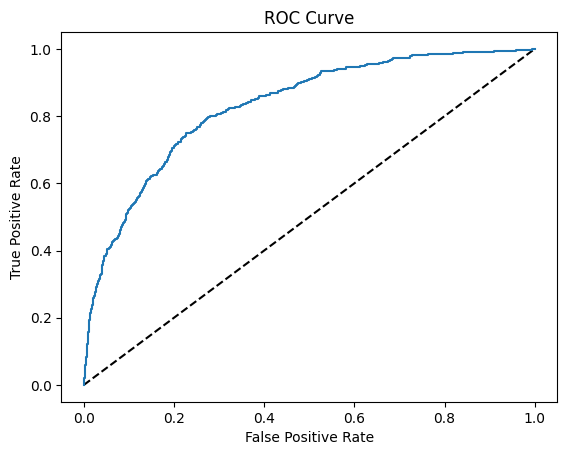

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [ ]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [ ]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [ ]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)